In [72]:
import requests
from statistics import mean, median
import datetime
import json
from datetime import timedelta
import pandas as pd
from IPython.display import display
from dateutil.relativedelta import relativedelta
import seaborn as sns
pd.options.mode.chained_assignment = None 
from tqdm import tqdm
from tabulate import tabulate
import matplotlib.pyplot as plt
import optuna

In [2]:
stats_weight = pd.read_csv("stats_weight.csv")

In [3]:
stats_weight.date = pd.to_datetime(stats_weight.date)

In [4]:
day_price = pd.read_csv("day_price.csv")

In [5]:
day_price.date = pd.to_datetime(day_price.date)

In [6]:
mango_btc_stat = pd.read_csv('BTC-PERP_funding_rates.csv')
mango_btc_stat['timestamp'] = pd.to_datetime(mango_btc_stat['hour']).dt.floor('1d')
mango_btc_stat_day = mango_btc_stat.groupby("timestamp").mean()

In [7]:
mango_eth_stat = pd.read_csv('ETH-PERP_funding_rates.csv')
mango_eth_stat['timestamp'] = pd.to_datetime(mango_eth_stat['hour']).dt.floor('1d')
mango_eth_stat_day = mango_eth_stat.groupby("timestamp").mean()

In [8]:
mango_avax_stat = pd.read_csv('AVAX-PERP_funding_rates.csv')
mango_avax_stat['timestamp'] = pd.to_datetime(mango_avax_stat['hour']).dt.floor('1d')
mango_avax_stat_day = mango_avax_stat.groupby("timestamp").mean()

In [9]:
# for each token (BTC / ETH / AVAX)
# calculating the size of the hedge position / PnL / funding
# pnl = start_usd__hedge_eth - position size * цену
# fund = ( position size * price ) * (daily funding / 100)
# start + pnl + fund

def calc_usd_position(token, date, position_size, startusd):
    if token == "ETH":
        df = mango_eth_stat_day
    elif token == "BTC":
        df = mango_btc_stat_day
    elif token == "AVAX":
        df = mango_avax_stat_day
    price = df.loc[date].avg_oracle_price
    funding_rate = df.loc[date].avg_funding_rate_pct
    usd_for_day = position_size * price
    pnl = startusd - usd_for_day
    fund = usd_for_day * funding_rate * 24 / 100
    return  [startusd + pnl, fund, price]
    

In [10]:
# visualization of graphs and results

def calc_apr(period, perc):
    return round((365 * perc/period),2)

def print_result(df):
    timediff = df.iloc[-1]["date"] - start_period
    print("period",timediff.days, "days")
    invest = df.iloc[-1]["invest"]
    disbalance = df.iloc[-1]["disbalance"]
    cost_hedge = df.iloc[-1]["total_fund"]
    glp_earn = df.iloc[-1]["glp_earn"]
    count_rebalance = df.iloc[-1]["count_rebalance"] 
    total_earn = df.iloc[-1]["total_sum"] - invest
    print("count_rebalance", count_rebalance)
    print(tabulate([['glp_earn', glp_earn, glp_earn/invest*100, calc_apr(timediff.days, glp_earn/invest*100) ], 
                    ['disbalance',disbalance,disbalance/invest*100 , calc_apr(timediff.days, disbalance/invest*100) ],
                    ['cost_hedge', cost_hedge, cost_hedge/invest*100, calc_apr(timediff.days, cost_hedge/invest*100)], 
                    ['total_earn', total_earn, total_earn/invest*100, calc_apr(timediff.days, total_earn/invest*100)]],headers=['Earn', 'USD', '%', 'Annualized']))
    fig, ax1 = plt.subplots(1,1,figsize=(30, 20))
    sns.lineplot(data=df[["usd_glp", "usd_headge", "total_sum" ]], ax=ax1)
    ax1.legend(["usd_glp", "usd_headge", "total_sum" ], loc="upper left", prop={'size': 20})
    ax2 = ax1.twinx()
    sns.lineplot(x=df.index, y=df.glp_price, color='tab:gray', label="GLP_price", lw=1, ax=ax2)
    ax2.legend(['GLP_price'], loc="upper right", prop={'size': 20})
    
    rebalance_date = df[df['rebalance']==True]
    ymax = df.sum_usd.max()
    for ind, xs in rebalance_date.iterrows():
        plt.vlines(x=ind, ymin=0, ymax=ymax, colors='purple', ls=':', lw=2, label='rebalance')
    plt.show()
    
    fig1, ax3 = plt.subplots(1,1,figsize=(20, 10))
    ax4 = ax3.twinx()
    sns.lineplot(x=df.index, y=df.disbalance, color='gray', ax=ax3)
    ax3.legend(["disbalance" ], loc="upper left", prop={'size': 20})
    
    sns.lineplot(data=df[['diff_abtc','diff_aeth','diff_aavax']], ax=ax4)
    ax2.legend(['diff_abtc','diff_aeth','diff_aavax' ], loc="upper right", prop={'size': 20})
        

In [11]:
# buy glp and open hedge positions

def input_balance(inputw, start_period, glp_invest, hedge_invest, day_price, stats_weight):
 
    rebalance_day_price = day_price[day_price["date"]==start_period]
    if inputw == "target":
        eth_r_w = eth_target
        btc_r_w = btc_target
        avax_r_w = avax_target
    elif inputw == "mean":
        eth_r_w = eth_mean
        btc_r_w = btc_mean
        avax_r_w = avax_mean
    else:
        glp_index = stats_weight[stats_weight["date"]==start_period]
        if len(glp_index.index)<4:
            start_period=start_period+pd.DateOffset(days=1)
            rebalance_day_price = day_price[day_price["date"]==start_period]
            glp_index = stats_weight_d[stats_weight_d["date"]==start_period]
        eth_r_w =  glp_index[glp_index["token_name"]=="WETH.e"].iloc[0]["weight"]
        btc_r_w = glp_index[glp_index["token_name"]=="WBTC.e"].iloc[0]["weight"]
        avax_r_w = glp_index[glp_index["token_name"]=="AVAX"].iloc[0]["weight"]
    
    start_price_glp = rebalance_day_price.iloc[0]['price']
    start_glp = glp_invest / start_price_glp # количество glp на старте
    
    # hedge with shorts based on the weight of tokens in the index
    start_usd_hedge_eth = hedge_invest * eth_r_w / 100
    start_hedge_eth = start_usd_hedge_eth / mango_eth_stat_day.loc[start_period].avg_oracle_price  

    start_usd_hedge_btc = hedge_invest * btc_r_w / 100
    start_hedge_btc = start_usd_hedge_btc / mango_btc_stat_day.loc[start_period].avg_oracle_price  

    start_usd_hedge_avax = hedge_invest * avax_r_w / 100
    start_hedge_avax = start_usd_hedge_avax / mango_avax_stat_day.loc[start_period].avg_oracle_price  

    start_usd_hedge_stable = hedge_invest - start_usd_hedge_eth  - start_usd_hedge_btc - start_usd_hedge_avax
    
    return [start_glp, 
            start_hedge_btc, 
            start_usd_hedge_btc, 
            start_hedge_eth, 
            start_usd_hedge_eth, 
            start_hedge_avax, 
            start_usd_hedge_avax]
        

In [12]:
def get_current_weight(df, name):
    weight = 0
    try:
        weight = df[df["token_name"]==name].iloc[0]["weight"]
    except:
        print(df[df["token_name"]==name].iloc[0])
        weight = 0
    return weight

In [27]:
def need_rebalance(diff_abtc, diff_aeth, diff_aavax, threshold):
    flag = abs(diff_abtc)>threshold or abs(diff_aeth)>threshold or abs(diff_aavax)>threshold
    return flag

## Test

In [14]:
params = {
    'invest' : 200,
    'apr_glp' : 0.25,
    'day_price': day_price, 
    'stats_weight': stats_weight,
}

In [ ]:
def test_param(inputw, start_days, end_days, threshold, **params):
    start_period = pd.to_datetime("2022-03-01") + pd.DateOffset(days=start_days)
    end_period = pd.to_datetime("2022-08-27") - pd.DateOffset(days=end_days)
    if start_period > end_period:
        return 100
    invest = params["invest"]
    apr_glp = params["apr_glp"]
    day_price =  params["day_price"]
    stats_weight =  params["stats_weight"]
        
    stats_usd = []
    glp_invest = invest / 2 
    hedge_invest = invest / 2

    day_price_filter = day_price[((day_price["date"]>=start_period)&(day_price["date"]<=end_period))].sort_values('date')
    
    start_glp, start_hedge_btc, start_usd_hedge_btc, start_hedge_eth, start_usd_hedge_eth, start_hedge_avax, start_usd_hedge_avax = input_balance(inputw, start_period, glp_invest, hedge_invest, day_price, stats_weight)

    start_usd_hedge_stable = hedge_invest - start_usd_hedge_eth  - start_usd_hedge_btc - start_usd_hedge_avax
    btc_sum_fund = 0
    eth_sum_fund = 0
    avax_sum_fund = 0
    glp_earn_sum = 0
    count_rebalance = 0
    
    for _, row in day_price_filter.iterrows():
        rebalance_flag = False
    
        # calculate glp position
        glp_index = stats_weight[stats_weight["date"]==row["date"]]
        glp_price = row["price"]
        usd_glp = start_glp * glp_price
    
        glp_earn_sum += usd_glp * apr_glp / 365
        
        """
        1) get the current weight
        2) calculating the distribution by quantity at the current weight
        3) check for a discrepancy within the threshold
        4) adjust the quantity if the discrepancy is greater than the threshold
        """
        
        current_glp_weight_btc = get_current_weight(glp_index, "WBTC.e")
        current_glp_weight_eth = get_current_weight(glp_index, "WETH.e")
        current_glp_weight_avax = get_current_weight(glp_index, "AVAX")

        usd_headge_btc, fund_btc,  price_btc = calc_usd_position("BTC",row["date"], start_hedge_btc, start_usd_hedge_btc)
        usd_headge_eth, fund_eth, price_eth = calc_usd_position("ETH", row["date"], start_hedge_eth, start_usd_hedge_eth)
        usd_headge_avax, fund_avax, price_avax = calc_usd_position("AVAX", row["date"], start_hedge_avax, start_usd_hedge_avax)
        usd_headge = usd_headge_btc + usd_headge_eth + usd_headge_avax + start_usd_hedge_stable
        
        # current weight (taking into account price changes)
        current_glp_amount_btc = ( usd_glp * current_glp_weight_btc / 100 ) / price_btc
        current_glp_amount_eth = ( usd_glp * current_glp_weight_eth / 100 ) / price_eth
        current_glp_amount_avax = ( usd_glp * current_glp_weight_avax / 100 ) / price_avax
        
        # calculate the amount change
        diff_abtc = (current_glp_amount_btc - start_hedge_btc) / start_hedge_btc
        diff_aeth = (current_glp_amount_eth - start_hedge_eth) / start_hedge_eth
        diff_aavax = (current_glp_amount_avax - start_hedge_avax) / start_hedge_avax
    
        if current_glp_amount_btc>0 and current_glp_amount_eth>0 and current_glp_amount_avax>0:
            if need_rebalance(diff_abtc, diff_aeth, diff_aavax, threshold):
                start_hedge_btc = current_glp_amount_btc
                start_usd_hedge_btc = current_glp_amount_btc*price_btc
                start_hedge_eth = current_glp_amount_eth
                start_usd_hedge_eth = current_glp_amount_eth*price_eth
                start_hedge_avax = current_glp_amount_avax
                start_usd_hedge_avax = current_glp_amount_avax*price_avax
                start_usd_hedge_stable = usd_headge - start_usd_hedge_btc - start_usd_hedge_eth - start_usd_hedge_avax
                rebalance_flag = True
                count_rebalance +=1
                if start_usd_hedge_stable<=0:
                    return [False, stats_usddf]
            
    
        btc_sum_fund += fund_btc
        eth_sum_fund += fund_eth
        avax_sum_fund += fund_avax
        total_fund = btc_sum_fund+eth_sum_fund+avax_sum_fund
        
        stats_usd.append({
            'date' : row['date'],
            'position_glp': start_glp,
            'glp_price': glp_price,
            'usd_glp' : usd_glp,
            'glp_earn': glp_earn_sum,
            'start_usd_hedge_stable': start_usd_hedge_stable,
            'usd_headge' : usd_headge,
            'total_fund': total_fund,
            'disbalance': usd_glp + usd_headge - invest,
            'disbalance_perc': 100*(usd_glp + usd_headge - invest)/invest,
            'invest': invest,
            'total_sum': usd_glp + usd_headge + glp_earn_sum + total_fund,
            'count_rebalance': count_rebalance,
            'rebalance': rebalance_flag,
            'sum_usd': usd_glp + usd_headge + glp_earn_sum + total_fund,
            'amount_btc': start_hedge_btc,
            'amount_eth': start_hedge_eth,
            'amount_avax': start_hedge_avax,        
            'curr_glp_amount_btc': current_glp_amount_btc,
            'curr_glp_amount_eth': current_glp_amount_eth,
            'curr_glp_amount_avax': current_glp_amount_avax,
            'diff_abtc': diff_abtc,
            'diff_aeth': diff_aeth,
            'diff_aavax': diff_aavax,
      
            })
    stats_usddf = pd.DataFrame(stats_usd)
    disbalance = stats_usddf.iloc[-1]["disbalance"]
    return disbalance

In [67]:
def run_test_abs(trial, start_days, end_days):
    threshold = trial.suggest_float('threshold', 0.1, 2, step=0.1)   
    disbalance = abs(test_param("current", start_days, end_days, threshold, **params))
    return disbalance

In [75]:
def run_test(trial, start_days, end_days):
    threshold = trial.suggest_float('threshold', 0.1, 2, step=0.1)   
    disbalance = test_param("current", start_days, end_days, threshold, **params)
    return disbalance

In [64]:
best = []
for start_days in range(10, 100, 10):
    for end_days in range(10, 50, 10):
        study = optuna.create_study(direction="minimize")
        study.optimize(lambda trial: run_test_abs(trial, start_days, end_days), n_trials=21, timeout=60*60*1)
        print(f'Best Parameters: ' + str(study.best_params))
        best.append(study.best_params["threshold"])


[I 2022-09-08 15:33:31,785] A new study created in memory with name: no-name-e1fb27cc-a332-4e48-9e58-345035c6514f
[I 2022-09-08 15:33:32,036] Trial 0 finished with value: 6.42310237070609 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 6.42310237070609.
[I 2022-09-08 15:33:32,254] Trial 1 finished with value: 6.935462723092257 and parameters: {'threshold': 1.4000000000000001}. Best is trial 0 with value: 6.42310237070609.
[I 2022-09-08 15:33:32,476] Trial 2 finished with value: 6.42310237070609 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 6.42310237070609.
[I 2022-09-08 15:33:32,697] Trial 3 finished with value: 2.4441368445433227 and parameters: {'threshold': 0.4}. Best is trial 3 with value: 2.4441368445433227.
[I 2022-09-08 15:33:32,917] Trial 4 finished with value: 2.779594130425039 and parameters: {'threshold': 0.9}. Best is trial 3 with value: 2.4441368445433227.
[I 2022-09-08 15:33:33,131] Trial 5 finished with val

Best Parameters: {'threshold': 0.2}


[I 2022-09-08 15:33:36,811] Trial 1 finished with value: 5.806552675465525 and parameters: {'threshold': 0.1}. Best is trial 0 with value: 0.03556197432050112.
[I 2022-09-08 15:33:37,017] Trial 2 finished with value: 5.525780904365632 and parameters: {'threshold': 1.6}. Best is trial 0 with value: 0.03556197432050112.
[I 2022-09-08 15:33:37,217] Trial 3 finished with value: 2.778073567708077 and parameters: {'threshold': 0.2}. Best is trial 0 with value: 0.03556197432050112.
[I 2022-09-08 15:33:37,867] Trial 4 finished with value: 5.806552675465525 and parameters: {'threshold': 0.1}. Best is trial 0 with value: 0.03556197432050112.
[I 2022-09-08 15:33:38,870] Trial 5 finished with value: 5.525780904365632 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 0.03556197432050112.
[I 2022-09-08 15:33:39,202] Trial 6 finished with value: 2.778073567708077 and parameters: {'threshold': 0.2}. Best is trial 0 with value: 0.03556197432050112.
[I 2022-09-08 15:33:39,41

Best Parameters: {'threshold': 0.7000000000000001}


[I 2022-09-08 15:33:42,441] Trial 1 finished with value: 3.2313877538704503 and parameters: {'threshold': 0.6}. Best is trial 1 with value: 3.2313877538704503.
[I 2022-09-08 15:33:42,627] Trial 2 finished with value: 7.749640676257201 and parameters: {'threshold': 0.1}. Best is trial 1 with value: 3.2313877538704503.
[I 2022-09-08 15:33:42,810] Trial 3 finished with value: 5.865456972531945 and parameters: {'threshold': 1.5000000000000002}. Best is trial 1 with value: 3.2313877538704503.
[I 2022-09-08 15:33:42,996] Trial 4 finished with value: 4.452698573094779 and parameters: {'threshold': 1.7000000000000002}. Best is trial 1 with value: 3.2313877538704503.
[I 2022-09-08 15:33:43,181] Trial 5 finished with value: 0.6842068651333477 and parameters: {'threshold': 1.2000000000000002}. Best is trial 5 with value: 0.6842068651333477.
[I 2022-09-08 15:33:43,365] Trial 6 finished with value: 5.14250679981717 and parameters: {'threshold': 0.8}. Best is trial 5 with value: 0.6842068651333477.


Best Parameters: {'threshold': 1.2000000000000002}


[I 2022-09-08 15:33:46,340] Trial 1 finished with value: 4.442912261046899 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 4.442912261046899.
[I 2022-09-08 15:33:46,517] Trial 2 finished with value: 3.8286204759388625 and parameters: {'threshold': 1.5000000000000002}. Best is trial 2 with value: 3.8286204759388625.
[I 2022-09-08 15:33:46,689] Trial 3 finished with value: 4.442912261046899 and parameters: {'threshold': 1.8000000000000003}. Best is trial 2 with value: 3.8286204759388625.
[I 2022-09-08 15:33:46,862] Trial 4 finished with value: 4.442912261046899 and parameters: {'threshold': 1.8000000000000003}. Best is trial 2 with value: 3.8286204759388625.
[I 2022-09-08 15:33:47,037] Trial 5 finished with value: 4.442912261046899 and parameters: {'threshold': 1.9000000000000001}. Best is trial 2 with value: 3.8286204759388625.
[I 2022-09-08 15:33:47,215] Trial 6 finished with value: 11.627839632559528 and parameters: {'threshold': 0.1}. Best is trial 2 wi

Best Parameters: {'threshold': 1.1}


[I 2022-09-08 15:33:50,066] Trial 1 finished with value: 7.516936649728024 and parameters: {'threshold': 1.3000000000000003}. Best is trial 0 with value: 0.1061927799766238.
[I 2022-09-08 15:33:50,276] Trial 2 finished with value: 0.18513077206944217 and parameters: {'threshold': 0.6}. Best is trial 0 with value: 0.1061927799766238.
[I 2022-09-08 15:33:50,484] Trial 3 finished with value: 7.516936649728024 and parameters: {'threshold': 1.6}. Best is trial 0 with value: 0.1061927799766238.
[I 2022-09-08 15:33:50,687] Trial 4 finished with value: 1.416994647938111 and parameters: {'threshold': 1.1}. Best is trial 0 with value: 0.1061927799766238.
[I 2022-09-08 15:33:50,891] Trial 5 finished with value: 8.502786066452302 and parameters: {'threshold': 1.8000000000000003}. Best is trial 0 with value: 0.1061927799766238.
[I 2022-09-08 15:33:51,113] Trial 6 finished with value: 0.18513077206944217 and parameters: {'threshold': 0.6}. Best is trial 0 with value: 0.1061927799766238.
[I 2022-09-0

Best Parameters: {'threshold': 0.4}


[I 2022-09-08 15:33:54,622] Trial 2 finished with value: 7.127383472660881 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 2.5401789266867354.
[I 2022-09-08 15:33:54,809] Trial 3 finished with value: 7.127383472660881 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 2.5401789266867354.
[I 2022-09-08 15:33:54,993] Trial 4 finished with value: 2.269820784486683 and parameters: {'threshold': 0.8}. Best is trial 4 with value: 2.269820784486683.
[I 2022-09-08 15:33:55,178] Trial 5 finished with value: 3.2067680035182207 and parameters: {'threshold': 0.4}. Best is trial 4 with value: 2.269820784486683.
[I 2022-09-08 15:33:55,364] Trial 6 finished with value: 3.2067680035182207 and parameters: {'threshold': 0.4}. Best is trial 4 with value: 2.269820784486683.
[I 2022-09-08 15:33:55,568] Trial 7 finished with value: 5.161147043306926 and parameters: {'threshold': 1.7000000000000002}. Best is trial 4 with value: 2.269820784486683.
[I 

Best Parameters: {'threshold': 0.8}


[I 2022-09-08 15:33:58,365] Trial 1 finished with value: 4.023545721113464 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 4.023545721113464.
[I 2022-09-08 15:33:58,537] Trial 2 finished with value: 1.9016290512593628 and parameters: {'threshold': 1.7000000000000002}. Best is trial 2 with value: 1.9016290512593628.
[I 2022-09-08 15:33:58,710] Trial 3 finished with value: 1.9016290512593628 and parameters: {'threshold': 1.3000000000000003}. Best is trial 2 with value: 1.9016290512593628.
[I 2022-09-08 15:33:58,881] Trial 4 finished with value: 6.044836646494417 and parameters: {'threshold': 1.9000000000000001}. Best is trial 2 with value: 1.9016290512593628.
[I 2022-09-08 15:33:59,049] Trial 5 finished with value: 6.044836646494417 and parameters: {'threshold': 1.9000000000000001}. Best is trial 2 with value: 1.9016290512593628.
[I 2022-09-08 15:33:59,220] Trial 6 finished with value: 5.835984872213203 and parameters: {'threshold': 0.8}. Best is trial 2 with value: 1.901

Best Parameters: {'threshold': 1.7000000000000002}


[I 2022-09-08 15:34:02,291] Trial 3 finished with value: 0.71889837733886 and parameters: {'threshold': 1.5000000000000002}. Best is trial 0 with value: 0.71889837733886.
[I 2022-09-08 15:34:02,452] Trial 4 finished with value: 8.722878419576858 and parameters: {'threshold': 0.4}. Best is trial 0 with value: 0.71889837733886.
[I 2022-09-08 15:34:02,609] Trial 5 finished with value: 4.547437062510397 and parameters: {'threshold': 0.9}. Best is trial 0 with value: 0.71889837733886.
[I 2022-09-08 15:34:02,766] Trial 6 finished with value: 8.243311893722847 and parameters: {'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.71889837733886.
[I 2022-09-08 15:34:02,926] Trial 7 finished with value: 4.610381180091423 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 0.71889837733886.
[I 2022-09-08 15:34:03,081] Trial 8 finished with value: 5.9702715494130985 and parameters: {'threshold': 2.0}. Best is trial 0 with value: 0.71889837733886.
[I 2022-09-08

Best Parameters: {'threshold': 1.8000000000000003}


[I 2022-09-08 15:34:05,382] Trial 1 finished with value: 9.276646443789502 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 6.943859327784821.
[I 2022-09-08 15:34:05,568] Trial 2 finished with value: 5.957707304044845 and parameters: {'threshold': 0.5}. Best is trial 2 with value: 5.957707304044845.
[I 2022-09-08 15:34:05,758] Trial 3 finished with value: 7.6209839816407055 and parameters: {'threshold': 0.2}. Best is trial 2 with value: 5.957707304044845.
[I 2022-09-08 15:34:05,940] Trial 4 finished with value: 4.225269029322675 and parameters: {'threshold': 0.6}. Best is trial 4 with value: 4.225269029322675.
[I 2022-09-08 15:34:06,122] Trial 5 finished with value: 4.225269029322675 and parameters: {'threshold': 0.6}. Best is trial 4 with value: 4.225269029322675.
[I 2022-09-08 15:34:06,303] Trial 6 finished with value: 5.352080207761901 and parameters: {'threshold': 1.2000000000000002}. Best is trial 4 with value: 4.225269029322675.
[I 2022-09-08 15:34:06,488] Trial 7 

Best Parameters: {'threshold': 1.5000000000000002}


[I 2022-09-08 15:34:09,277] Trial 1 finished with value: 5.071570449124806 and parameters: {'threshold': 1.6}. Best is trial 0 with value: 2.6542925190163373.
[I 2022-09-08 15:34:09,452] Trial 2 finished with value: 9.857130430581606 and parameters: {'threshold': 0.2}. Best is trial 0 with value: 2.6542925190163373.
[I 2022-09-08 15:34:09,628] Trial 3 finished with value: 13.286126839685835 and parameters: {'threshold': 0.1}. Best is trial 0 with value: 2.6542925190163373.
[I 2022-09-08 15:34:09,803] Trial 4 finished with value: 6.58166185489074 and parameters: {'threshold': 1.1}. Best is trial 0 with value: 2.6542925190163373.
[I 2022-09-08 15:34:09,980] Trial 5 finished with value: 6.58166185489074 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 2.6542925190163373.
[I 2022-09-08 15:34:10,154] Trial 6 finished with value: 7.012960969072253 and parameters: {'threshold': 0.6}. Best is trial 0 with value: 2.6542925190163373.
[I 2022-09-08 15:34:10,331] Tria

Best Parameters: {'threshold': 2.0}


[I 2022-09-08 15:34:13,123] Trial 2 finished with value: 4.5328523283442905 and parameters: {'threshold': 1.5000000000000002}. Best is trial 0 with value: 0.8705779400399933.
[I 2022-09-08 15:34:13,282] Trial 3 finished with value: 7.742742845713394 and parameters: {'threshold': 1.0}. Best is trial 0 with value: 0.8705779400399933.
[I 2022-09-08 15:34:13,440] Trial 4 finished with value: 10.925435884861372 and parameters: {'threshold': 0.6}. Best is trial 0 with value: 0.8705779400399933.
[I 2022-09-08 15:34:13,600] Trial 5 finished with value: 0.8705779400399933 and parameters: {'threshold': 2.0}. Best is trial 0 with value: 0.8705779400399933.
[I 2022-09-08 15:34:13,777] Trial 6 finished with value: 10.617439408549046 and parameters: {'threshold': 0.7000000000000001}. Best is trial 0 with value: 0.8705779400399933.
[I 2022-09-08 15:34:13,940] Trial 7 finished with value: 8.495325213285298 and parameters: {'threshold': 0.9}. Best is trial 0 with value: 0.8705779400399933.
[I 2022-09-0

Best Parameters: {'threshold': 2.0}


[I 2022-09-08 15:34:16,410] Trial 0 finished with value: 14.330821678220389 and parameters: {'threshold': 0.5}. Best is trial 0 with value: 14.330821678220389.
[I 2022-09-08 15:34:16,559] Trial 1 finished with value: 0.290249317602445 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 0.290249317602445.
[I 2022-09-08 15:34:16,709] Trial 2 finished with value: 5.5799920057372105 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 0.290249317602445.
[I 2022-09-08 15:34:16,853] Trial 3 finished with value: 17.017113132718578 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 0.290249317602445.
[I 2022-09-08 15:34:16,999] Trial 4 finished with value: 8.329586154913272 and parameters: {'threshold': 1.2000000000000002}. Best is trial 1 with value: 0.290249317602445.
[I 2022-09-08 15:34:17,145] Trial 5 finished with value: 8.329586154913272 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 0.290249317602445.
[I 

Best Parameters: {'threshold': 1.9000000000000001}


[I 2022-09-08 15:34:19,914] Trial 2 finished with value: 6.104192448946833 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 4.2285721005080745.
[I 2022-09-08 15:34:20,084] Trial 3 finished with value: 5.40751966805783 and parameters: {'threshold': 1.2000000000000002}. Best is trial 1 with value: 4.2285721005080745.
[I 2022-09-08 15:34:20,257] Trial 4 finished with value: 2.000671471421981 and parameters: {'threshold': 0.7000000000000001}. Best is trial 4 with value: 2.000671471421981.
[I 2022-09-08 15:34:20,427] Trial 5 finished with value: 4.2285721005080745 and parameters: {'threshold': 0.5}. Best is trial 4 with value: 2.000671471421981.
[I 2022-09-08 15:34:20,597] Trial 6 finished with value: 6.218270384893003 and parameters: {'threshold': 0.8}. Best is trial 4 with value: 2.000671471421981.
[I 2022-09-08 15:34:20,771] Trial 7 finished with value: 3.7991660253838404 and parameters: {'threshold': 1.8000000000000003}. Best is trial 4 with value: 2.000671471421981.
[I 2

Best Parameters: {'threshold': 0.7000000000000001}


[I 2022-09-08 15:34:23,436] Trial 1 finished with value: 2.9630336301724753 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 2.9630336301724753.
[I 2022-09-08 15:34:23,596] Trial 2 finished with value: 2.9630336301724753 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 2.9630336301724753.
[I 2022-09-08 15:34:23,785] Trial 3 finished with value: 3.679434334683066 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 2.9630336301724753.
[I 2022-09-08 15:34:23,952] Trial 4 finished with value: 2.9951018206944866 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 2.9630336301724753.
[I 2022-09-08 15:34:24,113] Trial 5 finished with value: 2.9630336301724753 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 2.9630336301724753.
[I 2022-09-08 15:34:24,274] Trial 6 finished with value: 2.9630336301724753 and parameters: {'threshold': 1.4000000000000001}. Best is trial 1 with value: 2.96303363017247

Best Parameters: {'threshold': 0.7000000000000001}


[I 2022-09-08 15:34:27,192] Trial 3 finished with value: 0.43144982650315455 and parameters: {'threshold': 1.4000000000000001}. Best is trial 0 with value: 0.43144982650315455.
[I 2022-09-08 15:34:27,338] Trial 4 finished with value: 7.2556346001996985 and parameters: {'threshold': 0.9}. Best is trial 0 with value: 0.43144982650315455.
[I 2022-09-08 15:34:27,485] Trial 5 finished with value: 2.0469657456960704 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 0.43144982650315455.
[I 2022-09-08 15:34:27,631] Trial 6 finished with value: 0.3143709657684326 and parameters: {'threshold': 1.5000000000000002}. Best is trial 6 with value: 0.3143709657684326.
[I 2022-09-08 15:34:27,779] Trial 7 finished with value: 8.456796750732849 and parameters: {'threshold': 0.2}. Best is trial 6 with value: 0.3143709657684326.
[I 2022-09-08 15:34:27,922] Trial 8 finished with value: 7.2556346001996985 and parameters: {'threshold': 0.9}. Best is trial 6 with value: 0.3143709657

Best Parameters: {'threshold': 1.5000000000000002}


[I 2022-09-08 15:34:29,970] Trial 1 finished with value: 3.222469814001613 and parameters: {'threshold': 1.0}. Best is trial 0 with value: 3.222469814001613.
[I 2022-09-08 15:34:30,104] Trial 2 finished with value: 7.057130958219261 and parameters: {'threshold': 0.7000000000000001}. Best is trial 0 with value: 3.222469814001613.
[I 2022-09-08 15:34:30,238] Trial 3 finished with value: 2.442242302705381 and parameters: {'threshold': 1.5000000000000002}. Best is trial 3 with value: 2.442242302705381.
[I 2022-09-08 15:34:30,371] Trial 4 finished with value: 3.222469814001613 and parameters: {'threshold': 1.0}. Best is trial 3 with value: 2.442242302705381.
[I 2022-09-08 15:34:30,504] Trial 5 finished with value: 3.222469814001613 and parameters: {'threshold': 1.3000000000000003}. Best is trial 3 with value: 2.442242302705381.
[I 2022-09-08 15:34:30,637] Trial 6 finished with value: 3.222469814001613 and parameters: {'threshold': 1.0}. Best is trial 3 with value: 2.442242302705381.
[I 2022

Best Parameters: {'threshold': 1.9000000000000001}


[I 2022-09-08 15:34:32,902] Trial 1 finished with value: 5.685898453041943 and parameters: {'threshold': 0.1}. Best is trial 1 with value: 5.685898453041943.
[I 2022-09-08 15:34:33,068] Trial 2 finished with value: 2.5249633026345464 and parameters: {'threshold': 0.30000000000000004}. Best is trial 2 with value: 2.5249633026345464.
[I 2022-09-08 15:34:33,225] Trial 3 finished with value: 7.896297793446337 and parameters: {'threshold': 1.2000000000000002}. Best is trial 2 with value: 2.5249633026345464.
[I 2022-09-08 15:34:33,386] Trial 4 finished with value: 1.4187257311844235 and parameters: {'threshold': 1.9000000000000001}. Best is trial 4 with value: 1.4187257311844235.
[I 2022-09-08 15:34:33,549] Trial 5 finished with value: 6.288478902248471 and parameters: {'threshold': 1.3000000000000003}. Best is trial 4 with value: 1.4187257311844235.
[I 2022-09-08 15:34:33,712] Trial 6 finished with value: 1.1245493263717492 and parameters: {'threshold': 0.9}. Best is trial 6 with value: 1.1

Best Parameters: {'threshold': 0.6}


[I 2022-09-08 15:34:36,491] Trial 2 finished with value: 7.401468025293298 and parameters: {'threshold': 0.5}. Best is trial 1 with value: 3.75005369554367.
[I 2022-09-08 15:34:36,638] Trial 3 finished with value: 8.50519475048344 and parameters: {'threshold': 0.8}. Best is trial 1 with value: 3.75005369554367.
[I 2022-09-08 15:34:36,787] Trial 4 finished with value: 4.555795784359134 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 3.75005369554367.
[I 2022-09-08 15:34:36,935] Trial 5 finished with value: 5.313290220277395 and parameters: {'threshold': 0.30000000000000004}. Best is trial 1 with value: 3.75005369554367.
[I 2022-09-08 15:34:37,104] Trial 6 finished with value: 5.149888496713743 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 3.75005369554367.
[I 2022-09-08 15:34:37,397] Trial 7 finished with value: 1.988531037482005 and parameters: {'threshold': 1.9000000000000001}. Best is trial 7 with value: 1.988531037482005.
[I 2022-09-08 15:34:37,822]

Best Parameters: {'threshold': 0.7000000000000001}


[I 2022-09-08 15:34:40,908] Trial 1 finished with value: 0.6082594977875431 and parameters: {'threshold': 1.4000000000000001}. Best is trial 1 with value: 0.6082594977875431.
[I 2022-09-08 15:34:41,042] Trial 2 finished with value: 5.659873673890758 and parameters: {'threshold': 0.4}. Best is trial 1 with value: 0.6082594977875431.
[I 2022-09-08 15:34:41,177] Trial 3 finished with value: 0.7418375797255408 and parameters: {'threshold': 1.8000000000000003}. Best is trial 1 with value: 0.6082594977875431.
[I 2022-09-08 15:34:41,313] Trial 4 finished with value: 2.2217986214761254 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 0.6082594977875431.
[I 2022-09-08 15:34:41,446] Trial 5 finished with value: 2.2217986214761254 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 0.6082594977875431.
[I 2022-09-08 15:34:41,582] Trial 6 finished with value: 7.012627256378153 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 0.608259497787543

Best Parameters: {'threshold': 1.4000000000000001}


[I 2022-09-08 15:34:43,868] Trial 2 finished with value: 7.8480667102348605 and parameters: {'threshold': 0.9}. Best is trial 0 with value: 2.0542576498247342.
[I 2022-09-08 15:34:43,989] Trial 3 finished with value: 12.662580586743843 and parameters: {'threshold': 0.5}. Best is trial 0 with value: 2.0542576498247342.
[I 2022-09-08 15:34:44,110] Trial 4 finished with value: 2.0542576498247342 and parameters: {'threshold': 1.4000000000000001}. Best is trial 0 with value: 2.0542576498247342.
[I 2022-09-08 15:34:44,231] Trial 5 finished with value: 1.9140800927272323 and parameters: {'threshold': 1.6}. Best is trial 5 with value: 1.9140800927272323.
[I 2022-09-08 15:34:44,352] Trial 6 finished with value: 9.281313077469378 and parameters: {'threshold': 0.4}. Best is trial 5 with value: 1.9140800927272323.
[I 2022-09-08 15:34:44,474] Trial 7 finished with value: 7.4046954611862645 and parameters: {'threshold': 0.7000000000000001}. Best is trial 5 with value: 1.9140800927272323.
[I 2022-09-

Best Parameters: {'threshold': 1.5000000000000002}


[I 2022-09-08 15:34:46,520] Trial 2 finished with value: 0.36169746641780876 and parameters: {'threshold': 0.4}. Best is trial 2 with value: 0.36169746641780876.
[I 2022-09-08 15:34:46,666] Trial 3 finished with value: 0.31659435252186086 and parameters: {'threshold': 0.2}. Best is trial 3 with value: 0.31659435252186086.
[I 2022-09-08 15:34:46,813] Trial 4 finished with value: 2.214876983941565 and parameters: {'threshold': 1.9000000000000001}. Best is trial 3 with value: 0.31659435252186086.
[I 2022-09-08 15:34:46,958] Trial 5 finished with value: 2.214876983941565 and parameters: {'threshold': 2.0}. Best is trial 3 with value: 0.31659435252186086.
[I 2022-09-08 15:34:47,105] Trial 6 finished with value: 2.214876983941565 and parameters: {'threshold': 2.0}. Best is trial 3 with value: 0.31659435252186086.
[I 2022-09-08 15:34:47,253] Trial 7 finished with value: 1.7663829417307682 and parameters: {'threshold': 0.7000000000000001}. Best is trial 3 with value: 0.31659435252186086.
[I 20

Best Parameters: {'threshold': 0.2}


[I 2022-09-08 15:34:49,729] Trial 2 finished with value: 1.3855165154066071 and parameters: {'threshold': 1.8000000000000003}. Best is trial 1 with value: 0.5597798862379761.
[I 2022-09-08 15:34:49,866] Trial 3 finished with value: 1.3855165154066071 and parameters: {'threshold': 1.8000000000000003}. Best is trial 1 with value: 0.5597798862379761.
[I 2022-09-08 15:34:50,003] Trial 4 finished with value: 1.3855165154066071 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 0.5597798862379761.
[I 2022-09-08 15:34:50,143] Trial 5 finished with value: 7.244003742881034 and parameters: {'threshold': 0.8}. Best is trial 1 with value: 0.5597798862379761.
[I 2022-09-08 15:34:50,285] Trial 6 finished with value: 1.611703410001212 and parameters: {'threshold': 1.2000000000000002}. Best is trial 1 with value: 0.5597798862379761.
[I 2022-09-08 15:34:50,424] Trial 7 finished with value: 3.464326466741852 and parameters: {'threshold': 0.4}. Best is trial 1 with value: 0.5597798862379761

Best Parameters: {'threshold': 0.7000000000000001}


[I 2022-09-08 15:34:52,934] Trial 1 finished with value: 7.551565694603255 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 0.4192411324026466.
[I 2022-09-08 15:34:53,269] Trial 2 finished with value: 5.075800296114096 and parameters: {'threshold': 0.30000000000000004}. Best is trial 0 with value: 0.4192411324026466.
[I 2022-09-08 15:34:53,437] Trial 3 finished with value: 1.551811973457859 and parameters: {'threshold': 0.9}. Best is trial 0 with value: 0.4192411324026466.
[I 2022-09-08 15:34:53,593] Trial 4 finished with value: 0.9514510229264488 and parameters: {'threshold': 1.3000000000000003}. Best is trial 0 with value: 0.4192411324026466.
[I 2022-09-08 15:34:53,872] Trial 5 finished with value: 0.472863405640112 and parameters: {'threshold': 1.0}. Best is trial 0 with value: 0.4192411324026466.
[I 2022-09-08 15:34:54,012] Trial 6 finished with value: 0.4192411324026466 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 0.4192411324026466

Best Parameters: {'threshold': 1.7000000000000002}


[I 2022-09-08 15:34:56,175] Trial 2 finished with value: 0.5599996322546303 and parameters: {'threshold': 2.0}. Best is trial 0 with value: 0.5599996322546303.
[I 2022-09-08 15:34:56,287] Trial 3 finished with value: 0.5599996322546303 and parameters: {'threshold': 1.6}. Best is trial 0 with value: 0.5599996322546303.
[I 2022-09-08 15:34:56,402] Trial 4 finished with value: 3.8466642176706785 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 0.5599996322546303.
[I 2022-09-08 15:34:56,519] Trial 5 finished with value: 7.198867714206955 and parameters: {'threshold': 1.4000000000000001}. Best is trial 0 with value: 0.5599996322546303.
[I 2022-09-08 15:34:56,630] Trial 6 finished with value: 3.8466642176706785 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 0.5599996322546303.
[I 2022-09-08 15:34:56,739] Trial 7 finished with value: 0.5599996322546303 and parameters: {'threshold': 1.5000000000000002}. Best is trial 0 with value: 0

Best Parameters: {'threshold': 1.5000000000000002}


[I 2022-09-08 15:34:58,622] Trial 2 finished with value: 1.5803764504474316 and parameters: {'threshold': 0.30000000000000004}. Best is trial 2 with value: 1.5803764504474316.
[I 2022-09-08 15:34:58,757] Trial 3 finished with value: 1.595939569471625 and parameters: {'threshold': 0.7000000000000001}. Best is trial 2 with value: 1.5803764504474316.
[I 2022-09-08 15:34:58,891] Trial 4 finished with value: 1.595939569471625 and parameters: {'threshold': 0.7000000000000001}. Best is trial 2 with value: 1.5803764504474316.
[I 2022-09-08 15:34:59,025] Trial 5 finished with value: 2.3390409401050647 and parameters: {'threshold': 1.7000000000000002}. Best is trial 2 with value: 1.5803764504474316.
[I 2022-09-08 15:34:59,160] Trial 6 finished with value: 2.3390409401050647 and parameters: {'threshold': 2.0}. Best is trial 2 with value: 1.5803764504474316.
[I 2022-09-08 15:34:59,294] Trial 7 finished with value: 1.3857060840759345 and parameters: {'threshold': 0.5}. Best is trial 7 with value: 1

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:35:01,522] Trial 2 finished with value: 0.6246558274962979 and parameters: {'threshold': 0.30000000000000004}. Best is trial 2 with value: 0.6246558274962979.
[I 2022-09-08 15:35:01,647] Trial 3 finished with value: 2.617588654192275 and parameters: {'threshold': 1.6}. Best is trial 2 with value: 0.6246558274962979.
[I 2022-09-08 15:35:01,768] Trial 4 finished with value: 3.3765028877306804 and parameters: {'threshold': 0.5}. Best is trial 2 with value: 0.6246558274962979.
[I 2022-09-08 15:35:01,890] Trial 5 finished with value: 0.745372082961751 and parameters: {'threshold': 0.6}. Best is trial 2 with value: 0.6246558274962979.
[I 2022-09-08 15:35:02,008] Trial 6 finished with value: 0.5140096221102226 and parameters: {'threshold': 0.4}. Best is trial 6 with value: 0.5140096221102226.
[I 2022-09-08 15:35:02,155] Trial 7 finished with value: 2.617588654192275 and parameters: {'threshold': 1.7000000000000002}. Best is trial 6 with value: 0.5140096221102226.
[I 2022-09-0

Best Parameters: {'threshold': 0.9}


[I 2022-09-08 15:35:04,086] Trial 2 finished with value: 2.257465237526617 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 1.769385862667832.
[I 2022-09-08 15:35:04,192] Trial 3 finished with value: 5.062694167865573 and parameters: {'threshold': 0.5}. Best is trial 1 with value: 1.769385862667832.
[I 2022-09-08 15:35:04,301] Trial 4 finished with value: 0.06225554714782788 and parameters: {'threshold': 0.2}. Best is trial 4 with value: 0.06225554714782788.
[I 2022-09-08 15:35:04,408] Trial 5 finished with value: 2.257465237526617 and parameters: {'threshold': 1.5000000000000002}. Best is trial 4 with value: 0.06225554714782788.
[I 2022-09-08 15:35:04,516] Trial 6 finished with value: 1.769385862667832 and parameters: {'threshold': 0.30000000000000004}. Best is trial 4 with value: 0.06225554714782788.
[I 2022-09-08 15:35:04,623] Trial 7 finished with value: 1.5859223575216674 and parameters: {'threshold': 1.3000000000000003}. Best is trial 4 with value: 0

Best Parameters: {'threshold': 0.2}


[I 2022-09-08 15:35:06,349] Trial 2 finished with value: 5.443479790370816 and parameters: {'threshold': 0.6}. Best is trial 1 with value: 0.9458414648015037.
[I 2022-09-08 15:35:06,444] Trial 3 finished with value: 0.9458414648015037 and parameters: {'threshold': 1.4000000000000001}. Best is trial 1 with value: 0.9458414648015037.
[I 2022-09-08 15:35:06,538] Trial 4 finished with value: 0.9458414648015037 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 0.9458414648015037.
[I 2022-09-08 15:35:06,634] Trial 5 finished with value: 0.042943192633629224 and parameters: {'threshold': 1.2000000000000002}. Best is trial 5 with value: 0.042943192633629224.
[I 2022-09-08 15:35:06,728] Trial 6 finished with value: 0.9458414648015037 and parameters: {'threshold': 1.8000000000000003}. Best is trial 5 with value: 0.042943192633629224.
[I 2022-09-08 15:35:06,826] Trial 7 finished with value: 0.9458414648015037 and parameters: {'threshold': 1.9000000000000001}. Best is 

Best Parameters: {'threshold': 1.2000000000000002}


[I 2022-09-08 15:35:08,406] Trial 1 finished with value: 2.0617847752278635 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 2.0617847752278635.
[I 2022-09-08 15:35:08,528] Trial 2 finished with value: 2.808240924879726 and parameters: {'threshold': 0.1}. Best is trial 0 with value: 2.0617847752278635.
[I 2022-09-08 15:35:08,650] Trial 3 finished with value: 1.2884084762199848 and parameters: {'threshold': 1.2000000000000002}. Best is trial 3 with value: 1.2884084762199848.
[I 2022-09-08 15:35:08,768] Trial 4 finished with value: 2.0617847752278635 and parameters: {'threshold': 1.5000000000000002}. Best is trial 3 with value: 1.2884084762199848.
[I 2022-09-08 15:35:08,892] Trial 5 finished with value: 2.0617847752278635 and parameters: {'threshold': 1.6}. Best is trial 3 with value: 1.2884084762199848.
[I 2022-09-08 15:35:09,012] Trial 6 finished with value: 1.2884084762199848 and parameters: {'threshold': 1.2000000000000002}. Best is trial 3 with value: 1

Best Parameters: {'threshold': 1.2000000000000002}


[I 2022-09-08 15:35:11,054] Trial 2 finished with value: 2.8875898868109573 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 0.33725097827652917.
[I 2022-09-08 15:35:11,163] Trial 3 finished with value: 2.8875898868109573 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 0.33725097827652917.
[I 2022-09-08 15:35:11,271] Trial 4 finished with value: 2.8875898868109573 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 0.33725097827652917.
[I 2022-09-08 15:35:11,382] Trial 5 finished with value: 2.8875898868109573 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 0.33725097827652917.
[I 2022-09-08 15:35:11,488] Trial 6 finished with value: 2.8875898868109573 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 0.33725097827652917.
[I 2022-09-08 15:35:11,597] Trial 7 finished with value: 2.8875898868109573 and parameters: {'threshold': 1.4000000000000001}. Best is trial 1 with va

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:35:13,559] Trial 4 finished with value: 0.7322796183875084 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 0.24908256945440144.
[I 2022-09-08 15:35:13,659] Trial 5 finished with value: 2.375906623703486 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 0.24908256945440144.
[I 2022-09-08 15:35:13,754] Trial 6 finished with value: 0.940215213970589 and parameters: {'threshold': 0.5}. Best is trial 1 with value: 0.24908256945440144.
[I 2022-09-08 15:35:13,853] Trial 7 finished with value: 0.7322796183875084 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 0.24908256945440144.
[I 2022-09-08 15:35:13,949] Trial 8 finished with value: 0.7322796183875084 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 0.24908256945440144.
[I 2022-09-08 15:35:14,044] Trial 9 finished with value: 2.375906623703486 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 0.24908256945440144.
[I 2022-09-08 15:35:14,144] Trial 10 

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:35:15,462] Trial 3 finished with value: 1.7415868759702278 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 1.7415868759702278.
[I 2022-09-08 15:35:15,547] Trial 4 finished with value: 1.7415868759702278 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 1.7415868759702278.
[I 2022-09-08 15:35:15,633] Trial 5 finished with value: 0.7892399804500201 and parameters: {'threshold': 0.2}. Best is trial 5 with value: 0.7892399804500201.
[I 2022-09-08 15:35:15,716] Trial 6 finished with value: 0.04116463333082265 and parameters: {'threshold': 0.30000000000000004}. Best is trial 6 with value: 0.04116463333082265.
[I 2022-09-08 15:35:15,798] Trial 7 finished with value: 0.7892399804500201 and parameters: {'threshold': 0.2}. Best is trial 6 with value: 0.04116463333082265.
[I 2022-09-08 15:35:15,881] Trial 8 finished with value: 1.8741409023983522 and parameters: {'threshold': 0.1}. Best is trial 6 with value: 0.041164633

Best Parameters: {'threshold': 0.7000000000000001}


[I 2022-09-08 15:35:17,257] Trial 2 finished with value: 5.380444334041613 and parameters: {'threshold': 0.6}. Best is trial 0 with value: 1.4820800794623779.
[I 2022-09-08 15:35:17,370] Trial 3 finished with value: 4.541889565606766 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 1.4820800794623779.
[I 2022-09-08 15:35:17,479] Trial 4 finished with value: 3.879192965169409 and parameters: {'threshold': 0.1}. Best is trial 0 with value: 1.4820800794623779.
[I 2022-09-08 15:35:17,599] Trial 5 finished with value: 4.541889565606766 and parameters: {'threshold': 0.9}. Best is trial 0 with value: 1.4820800794623779.
[I 2022-09-08 15:35:17,708] Trial 6 finished with value: 1.4820800794623779 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 1.4820800794623779.
[I 2022-09-08 15:35:17,816] Trial 7 finished with value: 1.4820800794623779 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 1.4820800794623779.
[I 2022-09-08 

Best Parameters: {'threshold': 1.5000000000000002}


[I 2022-09-08 15:35:19,755] Trial 4 finished with value: 2.104671321653086 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 2.104671321653086.
[I 2022-09-08 15:35:19,849] Trial 5 finished with value: 2.424261162395908 and parameters: {'threshold': 0.1}. Best is trial 0 with value: 2.104671321653086.
[I 2022-09-08 15:35:19,946] Trial 6 finished with value: 3.671628749318131 and parameters: {'threshold': 0.6}. Best is trial 0 with value: 2.104671321653086.
[I 2022-09-08 15:35:20,040] Trial 7 finished with value: 1.2999839372989754 and parameters: {'threshold': 0.5}. Best is trial 7 with value: 1.2999839372989754.
[I 2022-09-08 15:35:20,139] Trial 8 finished with value: 1.2999839372989754 and parameters: {'threshold': 0.5}. Best is trial 7 with value: 1.2999839372989754.
[I 2022-09-08 15:35:20,237] Trial 9 finished with value: 3.2237630328137925 and parameters: {'threshold': 0.4}. Best is trial 7 with value: 1.2999839372989754.
[I 2022-09-08 15:35:20,342] Tri

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:35:21,615] Trial 2 finished with value: 0.5428781774170375 and parameters: {'threshold': 0.9}. Best is trial 2 with value: 0.5428781774170375.
[I 2022-09-08 15:35:21,698] Trial 3 finished with value: 4.071751207433408 and parameters: {'threshold': 0.2}. Best is trial 2 with value: 0.5428781774170375.
[I 2022-09-08 15:35:21,782] Trial 4 finished with value: 2.2329468806477735 and parameters: {'threshold': 1.4000000000000001}. Best is trial 2 with value: 0.5428781774170375.
[I 2022-09-08 15:35:21,866] Trial 5 finished with value: 1.4125933262074 and parameters: {'threshold': 0.1}. Best is trial 2 with value: 0.5428781774170375.
[I 2022-09-08 15:35:21,946] Trial 6 finished with value: 2.2329468806477735 and parameters: {'threshold': 1.8000000000000003}. Best is trial 2 with value: 0.5428781774170375.
[I 2022-09-08 15:35:22,028] Trial 7 finished with value: 0.07178249659824587 and parameters: {'threshold': 0.5}. Best is trial 7 with value: 0.07178249659824587.
[I 2022-09-0

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:35:23,437] Trial 3 finished with value: 1.4814915519249894 and parameters: {'threshold': 1.7000000000000002}. Best is trial 1 with value: 0.6092169669308873.
[I 2022-09-08 15:35:23,506] Trial 4 finished with value: 2.014536803263894 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 0.6092169669308873.
[I 2022-09-08 15:35:23,574] Trial 5 finished with value: 0.6266421002537754 and parameters: {'threshold': 0.8}. Best is trial 1 with value: 0.6092169669308873.
[I 2022-09-08 15:35:23,644] Trial 6 finished with value: 0.6092169669308873 and parameters: {'threshold': 0.1}. Best is trial 1 with value: 0.6092169669308873.
[I 2022-09-08 15:35:23,712] Trial 7 finished with value: 0.309398483506925 and parameters: {'threshold': 0.6}. Best is trial 7 with value: 0.309398483506925.
[I 2022-09-08 15:35:23,781] Trial 8 finished with value: 0.7135308904442468 and parameters: {'threshold': 0.4}. Best is trial 7 with value: 0.309398483506925.
[I 2022-09-08 15:35:23,850] T

Best Parameters: {'threshold': 1.0}


In [69]:
mean(best)

1.0222222222222224

In [73]:
median(best)

0.95

In [76]:
best = []
for start_days in range(10, 100, 10):
    for end_days in range(10, 50, 10):
        study = optuna.create_study(direction="maximize")
        study.optimize(lambda trial: run_test(trial, start_days, end_days), n_trials=21, timeout=60*60*1)
        print(f'Best Parameters: ' + str(study.best_params))
        best.append(study.best_params["threshold"])

[I 2022-09-08 15:39:29,735] A new study created in memory with name: no-name-411c4417-5ebb-4e64-8a1d-6f3f9f0e6e83
[I 2022-09-08 15:39:29,979] Trial 0 finished with value: -6.059903550679138 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: -6.059903550679138.
[I 2022-09-08 15:39:30,190] Trial 1 finished with value: 3.5374150236419553 and parameters: {'threshold': 0.8}. Best is trial 1 with value: 3.5374150236419553.
[I 2022-09-08 15:39:30,398] Trial 2 finished with value: -2.4441368445433227 and parameters: {'threshold': 0.4}. Best is trial 1 with value: 3.5374150236419553.
[I 2022-09-08 15:39:30,605] Trial 3 finished with value: -6.42310237070609 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 3.5374150236419553.
[I 2022-09-08 15:39:30,817] Trial 4 finished with value: -6.42310237070609 and parameters: {'threshold': 1.7000000000000002}. Best is trial 1 with value: 3.5374150236419553.
[I 2022-09-08 15:39:31,025] Trial 5 finished with value: 

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:39:34,806] Trial 2 finished with value: -5.525780904365632 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 4.567127301780715.
[I 2022-09-08 15:39:35,004] Trial 3 finished with value: -5.525780904365632 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 4.567127301780715.
[I 2022-09-08 15:39:35,200] Trial 4 finished with value: -5.525780904365632 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 4.567127301780715.
[I 2022-09-08 15:39:35,398] Trial 5 finished with value: 3.8679885558514684 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 4.567127301780715.
[I 2022-09-08 15:39:35,599] Trial 6 finished with value: 2.778073567708077 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 4.567127301780715.
[I 2022-09-08 15:39:35,796] Trial 7 finished with value: -4.695937810614453 and parameters: {'threshold': 1.4000000000000001}. Best is trial 1 with value: 4.567127301780715.
[I 2022-09-08 15:

Best Parameters: {'threshold': 0.8}


[I 2022-09-08 15:39:39,943] Trial 0 finished with value: -4.452698573094779 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: -4.452698573094779.
[I 2022-09-08 15:39:40,136] Trial 1 finished with value: 7.749640676257201 and parameters: {'threshold': 0.1}. Best is trial 1 with value: 7.749640676257201.
[I 2022-09-08 15:39:40,324] Trial 2 finished with value: 4.718198984096745 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 7.749640676257201.
[I 2022-09-08 15:39:40,527] Trial 3 finished with value: 4.564519674683282 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 7.749640676257201.
[I 2022-09-08 15:39:40,715] Trial 4 finished with value: -0.6842068651333477 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 7.749640676257201.
[I 2022-09-08 15:39:40,904] Trial 5 finished with value: 6.699559437188412 and parameters: {'threshold': 0.5}. Best is trial 1 with value: 7.749640676257201.
[I 2022-09-08 15:3

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:39:44,341] Trial 2 finished with value: -4.442912261046899 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 11.627839632559528.
[I 2022-09-08 15:39:44,513] Trial 3 finished with value: 5.816716019444584 and parameters: {'threshold': 0.7000000000000001}. Best is trial 1 with value: 11.627839632559528.
[I 2022-09-08 15:39:44,682] Trial 4 finished with value: 5.290962006262703 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 11.627839632559528.
[I 2022-09-08 15:39:44,853] Trial 5 finished with value: -4.442912261046899 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 11.627839632559528.
[I 2022-09-08 15:39:45,023] Trial 6 finished with value: -4.442912261046899 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 11.627839632559528.
[I 2022-09-08 15:39:45,195] Trial 7 finished with value: -0.2171980529229245 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 11.627839632559528.
[I 2022-09-08 15:39:45,368

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:39:47,891] Trial 1 finished with value: -7.516936649728024 and parameters: {'threshold': 1.3000000000000003}. Best is trial 0 with value: 0.691037481616263.
[I 2022-09-08 15:39:48,087] Trial 2 finished with value: -7.516936649728024 and parameters: {'threshold': 1.4000000000000001}. Best is trial 0 with value: 0.691037481616263.
[I 2022-09-08 15:39:48,285] Trial 3 finished with value: 1.416994647938111 and parameters: {'threshold': 1.1}. Best is trial 3 with value: 1.416994647938111.
[I 2022-09-08 15:39:48,481] Trial 4 finished with value: 1.8920506938342214 and parameters: {'threshold': 1.0}. Best is trial 4 with value: 1.8920506938342214.
[I 2022-09-08 15:39:48,678] Trial 5 finished with value: -7.516936649728024 and parameters: {'threshold': 1.7000000000000002}. Best is trial 4 with value: 1.8920506938342214.
[I 2022-09-08 15:39:48,886] Trial 6 finished with value: -7.516936649728024 and parameters: {'threshold': 1.7000000000000002}. Best is trial 4 with value: 1.89

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:39:52,055] Trial 1 finished with value: 2.5401789266867354 and parameters: {'threshold': 1.1}. Best is trial 0 with value: 3.2067680035182207.
[I 2022-09-08 15:39:52,240] Trial 2 finished with value: -5.161147043306926 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 3.2067680035182207.
[I 2022-09-08 15:39:52,426] Trial 3 finished with value: -5.161147043306926 and parameters: {'threshold': 1.3000000000000003}. Best is trial 0 with value: 3.2067680035182207.
[I 2022-09-08 15:39:52,610] Trial 4 finished with value: 2.269820784486683 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 3.2067680035182207.
[I 2022-09-08 15:39:52,795] Trial 5 finished with value: -7.127383472660881 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 3.2067680035182207.
[I 2022-09-08 15:39:52,980] Trial 6 finished with value: -5.161147043306926 and parameters: {'threshold': 1.4000000000000001}. Best is trial 0 with value: 3

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:39:55,954] Trial 1 finished with value: -2.9564233154458464 and parameters: {'threshold': 1.8000000000000003}. Best is trial 0 with value: 3.767327074565401.
[I 2022-09-08 15:39:56,126] Trial 2 finished with value: 3.5196707726440764 and parameters: {'threshold': 1.1}. Best is trial 0 with value: 3.767327074565401.
[I 2022-09-08 15:39:56,298] Trial 3 finished with value: 10.18871600933096 and parameters: {'threshold': 0.5}. Best is trial 3 with value: 10.18871600933096.
[I 2022-09-08 15:39:56,469] Trial 4 finished with value: -1.9016290512593628 and parameters: {'threshold': 1.7000000000000002}. Best is trial 3 with value: 10.18871600933096.
[I 2022-09-08 15:39:56,640] Trial 5 finished with value: -1.9016290512593628 and parameters: {'threshold': 1.6}. Best is trial 3 with value: 10.18871600933096.
[I 2022-09-08 15:39:56,812] Trial 6 finished with value: -6.044836646494417 and parameters: {'threshold': 2.0}. Best is trial 3 with value: 10.18871600933096.
[I 2022-09-08 

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:39:59,817] Trial 2 finished with value: 10.300961820288506 and parameters: {'threshold': 0.30000000000000004}. Best is trial 2 with value: 10.300961820288506.
[I 2022-09-08 15:39:59,980] Trial 3 finished with value: 13.111946001336719 and parameters: {'threshold': 0.5}. Best is trial 3 with value: 13.111946001336719.
[I 2022-09-08 15:40:00,142] Trial 4 finished with value: 8.243311893722847 and parameters: {'threshold': 0.7000000000000001}. Best is trial 3 with value: 13.111946001336719.
[I 2022-09-08 15:40:00,299] Trial 5 finished with value: 10.967916532524299 and parameters: {'threshold': 0.2}. Best is trial 3 with value: 13.111946001336719.
[I 2022-09-08 15:40:00,458] Trial 6 finished with value: 8.934082520191794 and parameters: {'threshold': 0.6}. Best is trial 3 with value: 13.111946001336719.
[I 2022-09-08 15:40:00,617] Trial 7 finished with value: 0.71889837733886 and parameters: {'threshold': 1.7000000000000002}. Best is trial 3 with value: 13.111946001336719

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:02,974] Trial 0 finished with value: 5.957707304044845 and parameters: {'threshold': 0.5}. Best is trial 0 with value: 5.957707304044845.
[I 2022-09-08 15:40:03,162] Trial 1 finished with value: 3.520646443616073 and parameters: {'threshold': 1.6}. Best is trial 0 with value: 5.957707304044845.
[I 2022-09-08 15:40:03,347] Trial 2 finished with value: 1.2304619721726908 and parameters: {'threshold': 1.3000000000000003}. Best is trial 0 with value: 5.957707304044845.
[I 2022-09-08 15:40:03,540] Trial 3 finished with value: 4.6138251456531805 and parameters: {'threshold': 0.4}. Best is trial 0 with value: 5.957707304044845.
[I 2022-09-08 15:40:03,727] Trial 4 finished with value: 3.520646443616073 and parameters: {'threshold': 1.8000000000000003}. Best is trial 0 with value: 5.957707304044845.
[I 2022-09-08 15:40:03,910] Trial 5 finished with value: 4.225269029322675 and parameters: {'threshold': 0.6}. Best is trial 0 with value: 5.957707304044845.
[I 2022-09-08 15:40:

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:07,288] Trial 2 finished with value: 7.012960969072253 and parameters: {'threshold': 0.6}. Best is trial 2 with value: 7.012960969072253.
[I 2022-09-08 15:40:07,460] Trial 3 finished with value: 9.857130430581606 and parameters: {'threshold': 0.2}. Best is trial 3 with value: 9.857130430581606.
[I 2022-09-08 15:40:07,633] Trial 4 finished with value: 4.67604984075939 and parameters: {'threshold': 0.9}. Best is trial 3 with value: 9.857130430581606.
[I 2022-09-08 15:40:07,805] Trial 5 finished with value: 10.824163603594627 and parameters: {'threshold': 0.8}. Best is trial 5 with value: 10.824163603594627.
[I 2022-09-08 15:40:07,976] Trial 6 finished with value: 6.58166185489074 and parameters: {'threshold': 1.1}. Best is trial 5 with value: 10.824163603594627.
[I 2022-09-08 15:40:08,147] Trial 7 finished with value: 4.67604984075939 and parameters: {'threshold': 0.9}. Best is trial 5 with value: 10.824163603594627.
[I 2022-09-08 15:40:08,318] Trial 8 finished with v

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:10,887] Trial 2 finished with value: 5.1782988219496815 and parameters: {'threshold': 1.8000000000000003}. Best is trial 0 with value: 12.114186952341583.
[I 2022-09-08 15:40:11,046] Trial 3 finished with value: 7.64242860453237 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 12.114186952341583.
[I 2022-09-08 15:40:11,204] Trial 4 finished with value: 7.742742845713394 and parameters: {'threshold': 1.0}. Best is trial 0 with value: 12.114186952341583.
[I 2022-09-08 15:40:11,365] Trial 5 finished with value: 4.5328523283442905 and parameters: {'threshold': 1.5000000000000002}. Best is trial 0 with value: 12.114186952341583.
[I 2022-09-08 15:40:11,524] Trial 6 finished with value: 7.64242860453237 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 12.114186952341583.
[I 2022-09-08 15:40:11,684] Trial 7 finished with value: 4.5328523283442905 and parameters: {'threshold': 1.3000000000000003}. Best is trial 0 wi

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:14,242] Trial 2 finished with value: 12.44611446468781 and parameters: {'threshold': 0.8}. Best is trial 2 with value: 12.44611446468781.
[I 2022-09-08 15:40:14,390] Trial 3 finished with value: 14.467558245722955 and parameters: {'threshold': 0.4}. Best is trial 3 with value: 14.467558245722955.
[I 2022-09-08 15:40:14,535] Trial 4 finished with value: -1.268036270457344 and parameters: {'threshold': 2.0}. Best is trial 3 with value: 14.467558245722955.
[I 2022-09-08 15:40:14,680] Trial 5 finished with value: 17.017113132718578 and parameters: {'threshold': 0.2}. Best is trial 5 with value: 17.017113132718578.
[I 2022-09-08 15:40:14,828] Trial 6 finished with value: 12.44611446468781 and parameters: {'threshold': 0.8}. Best is trial 5 with value: 17.017113132718578.
[I 2022-09-08 15:40:14,973] Trial 7 finished with value: 6.114269466096289 and parameters: {'threshold': 1.6}. Best is trial 5 with value: 17.017113132718578.
[I 2022-09-08 15:40:15,118] Trial 8 finished

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:17,296] Trial 1 finished with value: 4.2285721005080745 and parameters: {'threshold': 0.5}. Best is trial 0 with value: 4.9631997337409075.
[I 2022-09-08 15:40:17,469] Trial 2 finished with value: -2.000671471421981 and parameters: {'threshold': 0.7000000000000001}. Best is trial 0 with value: 4.9631997337409075.
[I 2022-09-08 15:40:17,668] Trial 3 finished with value: -3.7991660253838404 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 4.9631997337409075.
[I 2022-09-08 15:40:17,849] Trial 4 finished with value: -5.40751966805783 and parameters: {'threshold': 1.1}. Best is trial 0 with value: 4.9631997337409075.
[I 2022-09-08 15:40:18,029] Trial 5 finished with value: -5.40751966805783 and parameters: {'threshold': 1.1}. Best is trial 0 with value: 4.9631997337409075.
[I 2022-09-08 15:40:18,216] Trial 6 finished with value: -5.40751966805783 and parameters: {'threshold': 1.3000000000000003}. Best is trial 0 with value: 4.963199733740907

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:21,002] Trial 1 finished with value: -2.9630336301724753 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: -2.9630336301724753.
[I 2022-09-08 15:40:21,162] Trial 2 finished with value: 6.198797233996089 and parameters: {'threshold': 0.9}. Best is trial 2 with value: 6.198797233996089.
[I 2022-09-08 15:40:21,324] Trial 3 finished with value: -2.9630336301724753 and parameters: {'threshold': 1.3000000000000003}. Best is trial 2 with value: 6.198797233996089.
[I 2022-09-08 15:40:21,490] Trial 4 finished with value: 6.198797233996089 and parameters: {'threshold': 0.9}. Best is trial 2 with value: 6.198797233996089.
[I 2022-09-08 15:40:21,648] Trial 5 finished with value: -2.9951018206944866 and parameters: {'threshold': 2.0}. Best is trial 2 with value: 6.198797233996089.
[I 2022-09-08 15:40:21,807] Trial 6 finished with value: -2.9951018206944866 and parameters: {'threshold': 1.7000000000000002}. Best is trial 2 with value: 6.19879723399608

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:40:24,366] Trial 1 finished with value: -2.0469657456960704 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 0.43144982650315455.
[I 2022-09-08 15:40:24,514] Trial 2 finished with value: -2.0469657456960704 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: 0.43144982650315455.
[I 2022-09-08 15:40:24,659] Trial 3 finished with value: -2.0469657456960704 and parameters: {'threshold': 2.0}. Best is trial 0 with value: 0.43144982650315455.
[I 2022-09-08 15:40:24,809] Trial 4 finished with value: 8.122107492661144 and parameters: {'threshold': 0.6}. Best is trial 4 with value: 8.122107492661144.
[I 2022-09-08 15:40:24,955] Trial 5 finished with value: -0.3143709657684326 and parameters: {'threshold': 1.5000000000000002}. Best is trial 4 with value: 8.122107492661144.
[I 2022-09-08 15:40:25,100] Trial 6 finished with value: 0.43144982650315455 and parameters: {'threshold': 1.2000000000000002}. Best is trial 4 with va

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:27,581] Trial 2 finished with value: -2.116942900084098 and parameters: {'threshold': 1.8000000000000003}. Best is trial 1 with value: 16.506019203441724.
[I 2022-09-08 15:40:27,715] Trial 3 finished with value: 7.057130958219261 and parameters: {'threshold': 0.7000000000000001}. Best is trial 1 with value: 16.506019203441724.
[I 2022-09-08 15:40:27,848] Trial 4 finished with value: 11.87852588954621 and parameters: {'threshold': 0.30000000000000004}. Best is trial 1 with value: 16.506019203441724.
[I 2022-09-08 15:40:27,982] Trial 5 finished with value: 3.222469814001613 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 16.506019203441724.
[I 2022-09-08 15:40:28,115] Trial 6 finished with value: 3.222469814001613 and parameters: {'threshold': 1.4000000000000001}. Best is trial 1 with value: 16.506019203441724.
[I 2022-09-08 15:40:28,254] Trial 7 finished with value: -2.116942900084098 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:30,481] Trial 2 finished with value: -6.412630014994022 and parameters: {'threshold': 1.7000000000000002}. Best is trial 0 with value: -1.1245493263717492.
[I 2022-09-08 15:40:30,640] Trial 3 finished with value: 1.4187257311844235 and parameters: {'threshold': 1.9000000000000001}. Best is trial 3 with value: 1.4187257311844235.
[I 2022-09-08 15:40:30,797] Trial 4 finished with value: 3.730274575878923 and parameters: {'threshold': 1.1}. Best is trial 4 with value: 3.730274575878923.
[I 2022-09-08 15:40:30,960] Trial 5 finished with value: 1.4187257311844235 and parameters: {'threshold': 1.9000000000000001}. Best is trial 4 with value: 3.730274575878923.
[I 2022-09-08 15:40:31,119] Trial 6 finished with value: 4.885919142910666 and parameters: {'threshold': 0.5}. Best is trial 6 with value: 4.885919142910666.
[I 2022-09-08 15:40:31,277] Trial 7 finished with value: 2.530624213612583 and parameters: {'threshold': 0.2}. Best is trial 6 with value: 4.885919142910666.
[

Best Parameters: {'threshold': 1.2000000000000002}


[I 2022-09-08 15:40:33,672] Trial 1 finished with value: 5.149888496713743 and parameters: {'threshold': 1.1}. Best is trial 1 with value: 5.149888496713743.
[I 2022-09-08 15:40:33,821] Trial 2 finished with value: -4.034300660281133 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 5.149888496713743.
[I 2022-09-08 15:40:33,971] Trial 3 finished with value: 1.988531037482005 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 5.149888496713743.
[I 2022-09-08 15:40:34,117] Trial 4 finished with value: -3.050094108732935 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 5.149888496713743.
[I 2022-09-08 15:40:34,263] Trial 5 finished with value: 8.02552163791529 and parameters: {'threshold': 0.1}. Best is trial 5 with value: 8.02552163791529.
[I 2022-09-08 15:40:34,415] Trial 6 finished with value: 8.50519475048344 and parameters: {'threshold': 0.8}. Best is trial 6 with value: 8.50519475048344.
[I 2022-09-08 15:40:34,563] Trial 7 fin

Best Parameters: {'threshold': 0.8}


[I 2022-09-08 15:40:36,836] Trial 1 finished with value: -1.075004093927987 and parameters: {'threshold': 1.5000000000000002}. Best is trial 0 with value: 4.501867842804501.
[I 2022-09-08 15:40:36,975] Trial 2 finished with value: -0.7418375797255408 and parameters: {'threshold': 1.8000000000000003}. Best is trial 0 with value: 4.501867842804501.
[I 2022-09-08 15:40:37,112] Trial 3 finished with value: 2.2217986214761254 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 4.501867842804501.
[I 2022-09-08 15:40:37,249] Trial 4 finished with value: -1.075004093927987 and parameters: {'threshold': 1.5000000000000002}. Best is trial 0 with value: 4.501867842804501.
[I 2022-09-08 15:40:37,760] Trial 5 finished with value: 8.996210414614183 and parameters: {'threshold': 0.8}. Best is trial 5 with value: 8.996210414614183.
[I 2022-09-08 15:40:37,971] Trial 6 finished with value: 6.538728005528441 and parameters: {'threshold': 0.2}. Best is trial 5 with value: 8.9962

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:40:42,207] Trial 2 finished with value: 14.480177151161712 and parameters: {'threshold': 0.1}. Best is trial 2 with value: 14.480177151161712.
[I 2022-09-08 15:40:42,327] Trial 3 finished with value: 1.9140800927272323 and parameters: {'threshold': 1.8000000000000003}. Best is trial 2 with value: 14.480177151161712.
[I 2022-09-08 15:40:42,449] Trial 4 finished with value: 9.997481552024993 and parameters: {'threshold': 1.2000000000000002}. Best is trial 2 with value: 14.480177151161712.
[I 2022-09-08 15:40:42,570] Trial 5 finished with value: 9.997481552024993 and parameters: {'threshold': 1.2000000000000002}. Best is trial 2 with value: 14.480177151161712.
[I 2022-09-08 15:40:42,697] Trial 6 finished with value: 14.480177151161712 and parameters: {'threshold': 0.1}. Best is trial 2 with value: 14.480177151161712.
[I 2022-09-08 15:40:42,819] Trial 7 finished with value: 1.9140800927272323 and parameters: {'threshold': 1.6}. Best is trial 2 with value: 14.48017715116171

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:44,913] Trial 2 finished with value: 5.970142222270795 and parameters: {'threshold': 0.8}. Best is trial 2 with value: 5.970142222270795.
[I 2022-09-08 15:40:45,060] Trial 3 finished with value: -3.8730096430342087 and parameters: {'threshold': 1.1}. Best is trial 2 with value: 5.970142222270795.
[I 2022-09-08 15:40:45,207] Trial 4 finished with value: -4.375561557624366 and parameters: {'threshold': 1.3000000000000003}. Best is trial 2 with value: 5.970142222270795.
[I 2022-09-08 15:40:45,353] Trial 5 finished with value: -5.154294569098624 and parameters: {'threshold': 1.0}. Best is trial 2 with value: 5.970142222270795.
[I 2022-09-08 15:40:45,501] Trial 6 finished with value: -1.7663829417307682 and parameters: {'threshold': 0.7000000000000001}. Best is trial 2 with value: 5.970142222270795.
[I 2022-09-08 15:40:45,647] Trial 7 finished with value: -3.8730096430342087 and parameters: {'threshold': 1.2000000000000002}. Best is trial 2 with value: 5.970142222270795.

Best Parameters: {'threshold': 0.8}


[I 2022-09-08 15:40:48,005] Trial 2 finished with value: 3.55361164574299 and parameters: {'threshold': 0.30000000000000004}. Best is trial 1 with value: 3.55361164574299.
[I 2022-09-08 15:40:48,143] Trial 3 finished with value: 5.889081410914628 and parameters: {'threshold': 0.1}. Best is trial 3 with value: 5.889081410914628.
[I 2022-09-08 15:40:48,279] Trial 4 finished with value: 5.889081410914628 and parameters: {'threshold': 0.1}. Best is trial 3 with value: 5.889081410914628.
[I 2022-09-08 15:40:48,413] Trial 5 finished with value: -2.128712803617134 and parameters: {'threshold': 1.3000000000000003}. Best is trial 3 with value: 5.889081410914628.
[I 2022-09-08 15:40:48,561] Trial 6 finished with value: 3.55361164574299 and parameters: {'threshold': 0.30000000000000004}. Best is trial 3 with value: 5.889081410914628.
[I 2022-09-08 15:40:48,700] Trial 7 finished with value: -1.3855165154066071 and parameters: {'threshold': 1.5000000000000002}. Best is trial 3 with value: 5.8890814

Best Parameters: {'threshold': 0.8}


[I 2022-09-08 15:40:50,704] Trial 1 finished with value: 1.551811973457859 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 1.551811973457859.
[I 2022-09-08 15:40:50,831] Trial 2 finished with value: 0.472863405640112 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 1.551811973457859.
[I 2022-09-08 15:40:50,952] Trial 3 finished with value: 7.758066365762716 and parameters: {'threshold': 0.1}. Best is trial 3 with value: 7.758066365762716.
[I 2022-09-08 15:40:51,083] Trial 4 finished with value: 7.551565694603255 and parameters: {'threshold': 0.8}. Best is trial 3 with value: 7.758066365762716.
[I 2022-09-08 15:40:51,307] Trial 5 finished with value: 8.618969239958915 and parameters: {'threshold': 0.5}. Best is trial 5 with value: 8.618969239958915.
[I 2022-09-08 15:40:51,462] Trial 6 finished with value: 1.551811973457859 and parameters: {'threshold': 0.9}. Best is trial 5 with value: 8.618969239958915.
[I 2022-09-08 15:40:51,585] Trial 7 finished with va

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:40:53,506] Trial 2 finished with value: -0.5599996322546303 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 8.315911804541486.
[I 2022-09-08 15:40:53,617] Trial 3 finished with value: 3.28287976865181 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 8.315911804541486.
[I 2022-09-08 15:40:53,725] Trial 4 finished with value: 3.28287976865181 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 8.315911804541486.
[I 2022-09-08 15:40:53,833] Trial 5 finished with value: -0.5599996322546303 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 8.315911804541486.
[I 2022-09-08 15:40:53,944] Trial 6 finished with value: -0.5599996322546303 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 8.315911804541486.
[I 2022-09-08 15:40:54,051] Trial 7 finished with value: 11.488593948928099 and parameters: {'threshold': 0.1}. Best is trial 7 with value: 11.488

Best Parameters: {'threshold': 0.1}


[I 2022-09-08 15:40:55,756] Trial 1 finished with value: -2.7388188019411928 and parameters: {'threshold': 0.2}. Best is trial 1 with value: -2.7388188019411928.
[I 2022-09-08 15:40:55,891] Trial 2 finished with value: 2.3390409401050647 and parameters: {'threshold': 1.5000000000000002}. Best is trial 2 with value: 2.3390409401050647.
[I 2022-09-08 15:40:56,029] Trial 3 finished with value: -2.1970184292722763 and parameters: {'threshold': 0.4}. Best is trial 2 with value: 2.3390409401050647.
[I 2022-09-08 15:40:56,164] Trial 4 finished with value: -4.1742203781666944 and parameters: {'threshold': 1.2000000000000002}. Best is trial 2 with value: 2.3390409401050647.
[I 2022-09-08 15:40:56,297] Trial 5 finished with value: -4.1742203781666944 and parameters: {'threshold': 1.2000000000000002}. Best is trial 2 with value: 2.3390409401050647.
[I 2022-09-08 15:40:56,434] Trial 6 finished with value: -1.8426801396166184 and parameters: {'threshold': 0.9}. Best is trial 2 with value: 2.3390409

Best Parameters: {'threshold': 1.5000000000000002}


[I 2022-09-08 15:40:58,609] Trial 1 finished with value: 3.3765028877306804 and parameters: {'threshold': 0.5}. Best is trial 1 with value: 3.3765028877306804.
[I 2022-09-08 15:40:58,731] Trial 2 finished with value: 2.617588654192275 and parameters: {'threshold': 1.4000000000000001}. Best is trial 1 with value: 3.3765028877306804.
[I 2022-09-08 15:40:58,853] Trial 3 finished with value: 1.2492782683315795 and parameters: {'threshold': 0.1}. Best is trial 1 with value: 3.3765028877306804.
[I 2022-09-08 15:40:58,973] Trial 4 finished with value: 2.617588654192275 and parameters: {'threshold': 1.5000000000000002}. Best is trial 1 with value: 3.3765028877306804.
[I 2022-09-08 15:40:59,094] Trial 5 finished with value: -1.2255992949483243 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 3.3765028877306804.
[I 2022-09-08 15:40:59,214] Trial 6 finished with value: -2.142482008900515 and parameters: {'threshold': 1.2000000000000002}. Best is trial 1 with value: 3.37650288773068

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:41:01,275] Trial 2 finished with value: 2.257465237526617 and parameters: {'threshold': 2.0}. Best is trial 0 with value: 2.257465237526617.
[I 2022-09-08 15:41:01,382] Trial 3 finished with value: 2.671076054949424 and parameters: {'threshold': 0.1}. Best is trial 3 with value: 2.671076054949424.
[I 2022-09-08 15:41:01,490] Trial 4 finished with value: -1.5859223575216674 and parameters: {'threshold': 1.2000000000000002}. Best is trial 3 with value: 2.671076054949424.
[I 2022-09-08 15:41:01,596] Trial 5 finished with value: -4.2071552664635306 and parameters: {'threshold': 1.1}. Best is trial 3 with value: 2.671076054949424.
[I 2022-09-08 15:41:01,704] Trial 6 finished with value: 2.257465237526617 and parameters: {'threshold': 1.6}. Best is trial 3 with value: 2.671076054949424.
[I 2022-09-08 15:41:01,813] Trial 7 finished with value: -4.2071552664635306 and parameters: {'threshold': 1.1}. Best is trial 3 with value: 2.671076054949424.
[I 2022-09-08 15:41:01,920] Tri

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:41:03,520] Trial 2 finished with value: -2.009187060540796 and parameters: {'threshold': 1.1}. Best is trial 0 with value: 0.9458414648015037.
[I 2022-09-08 15:41:03,614] Trial 3 finished with value: 0.9458414648015037 and parameters: {'threshold': 1.8000000000000003}. Best is trial 0 with value: 0.9458414648015037.
[I 2022-09-08 15:41:03,710] Trial 4 finished with value: 0.9458414648015037 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 0.9458414648015037.
[I 2022-09-08 15:41:03,804] Trial 5 finished with value: 6.808264402010536 and parameters: {'threshold': 0.5}. Best is trial 5 with value: 6.808264402010536.
[I 2022-09-08 15:41:03,903] Trial 6 finished with value: 0.9458414648015037 and parameters: {'threshold': 1.5000000000000002}. Best is trial 5 with value: 6.808264402010536.
[I 2022-09-08 15:41:03,997] Trial 7 finished with value: 4.870450787747245 and parameters: {'threshold': 0.8}. Best is trial 5 with value: 6.808264402010536.


Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:41:05,626] Trial 2 finished with value: -1.2884084762199848 and parameters: {'threshold': 1.1}. Best is trial 1 with value: -1.2884084762199848.
[I 2022-09-08 15:41:05,747] Trial 3 finished with value: 2.0617847752278635 and parameters: {'threshold': 2.0}. Best is trial 3 with value: 2.0617847752278635.
[I 2022-09-08 15:41:05,873] Trial 4 finished with value: -1.2884084762199848 and parameters: {'threshold': 1.2000000000000002}. Best is trial 3 with value: 2.0617847752278635.
[I 2022-09-08 15:41:05,994] Trial 5 finished with value: -3.912755912758115 and parameters: {'threshold': 0.30000000000000004}. Best is trial 3 with value: 2.0617847752278635.
[I 2022-09-08 15:41:06,115] Trial 6 finished with value: -4.490927384312556 and parameters: {'threshold': 0.6}. Best is trial 3 with value: 2.0617847752278635.
[I 2022-09-08 15:41:06,235] Trial 7 finished with value: 2.0617847752278635 and parameters: {'threshold': 1.4000000000000001}. Best is trial 3 with value: 2.061784775

Best Parameters: {'threshold': 2.0}


[I 2022-09-08 15:41:08,162] Trial 2 finished with value: -3.8797494670769765 and parameters: {'threshold': 0.2}. Best is trial 0 with value: -0.3512538027567871.
[I 2022-09-08 15:41:08,277] Trial 3 finished with value: 2.8875898868109573 and parameters: {'threshold': 1.4000000000000001}. Best is trial 3 with value: 2.8875898868109573.
[I 2022-09-08 15:41:08,389] Trial 4 finished with value: -2.287027940686272 and parameters: {'threshold': 0.4}. Best is trial 3 with value: 2.8875898868109573.
[I 2022-09-08 15:41:08,497] Trial 5 finished with value: -3.8797494670769765 and parameters: {'threshold': 0.2}. Best is trial 3 with value: 2.8875898868109573.
[I 2022-09-08 15:41:08,620] Trial 6 finished with value: -0.3512538027567871 and parameters: {'threshold': 1.1}. Best is trial 3 with value: 2.8875898868109573.
[I 2022-09-08 15:41:08,732] Trial 7 finished with value: -6.1183336663262935 and parameters: {'threshold': 0.8}. Best is trial 3 with value: 2.8875898868109573.
[I 2022-09-08 15:41:

Best Parameters: {'threshold': 1.4000000000000001}


[I 2022-09-08 15:41:10,661] Trial 2 finished with value: -5.658486159316226 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 2.375906623703486.
[I 2022-09-08 15:41:10,759] Trial 3 finished with value: 2.375906623703486 and parameters: {'threshold': 1.9000000000000001}. Best is trial 0 with value: 2.375906623703486.
[I 2022-09-08 15:41:10,855] Trial 4 finished with value: 0.7322796183875084 and parameters: {'threshold': 1.2000000000000002}. Best is trial 0 with value: 2.375906623703486.
[I 2022-09-08 15:41:10,950] Trial 5 finished with value: -2.948406005085218 and parameters: {'threshold': 0.2}. Best is trial 0 with value: 2.375906623703486.
[I 2022-09-08 15:41:11,044] Trial 6 finished with value: -5.658486159316226 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 2.375906623703486.
[I 2022-09-08 15:41:11,138] Trial 7 finished with value: -5.658486159316226 and parameters: {'threshold': 0.8}. Best is trial 0 with value: 2.375906623703486.
[I 2022-09-08 15:

Best Parameters: {'threshold': 1.4000000000000001}


[I 2022-09-08 15:41:12,794] Trial 2 finished with value: 1.7415868759702278 and parameters: {'threshold': 1.8000000000000003}. Best is trial 1 with value: 1.7415868759702278.
[I 2022-09-08 15:41:12,877] Trial 3 finished with value: -0.7892399804500201 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 1.7415868759702278.
[I 2022-09-08 15:41:12,960] Trial 4 finished with value: -3.255061112905196 and parameters: {'threshold': 0.8}. Best is trial 1 with value: 1.7415868759702278.
[I 2022-09-08 15:41:13,041] Trial 5 finished with value: 0.7644371175057074 and parameters: {'threshold': 0.6}. Best is trial 1 with value: 1.7415868759702278.
[I 2022-09-08 15:41:13,123] Trial 6 finished with value: 0.5243481182569099 and parameters: {'threshold': 1.0}. Best is trial 1 with value: 1.7415868759702278.
[I 2022-09-08 15:41:13,204] Trial 7 finished with value: 1.7415868759702278 and parameters: {'threshold': 1.3000000000000003}. Best is trial 1 with value: 1.7415868759702278.
[I 2022-0

Best Parameters: {'threshold': 0.5}


[I 2022-09-08 15:41:14,715] Trial 2 finished with value: 1.4820800794623779 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 1.4820800794623779.
[I 2022-09-08 15:41:14,841] Trial 3 finished with value: 1.4820800794623779 and parameters: {'threshold': 1.5000000000000002}. Best is trial 1 with value: 1.4820800794623779.
[I 2022-09-08 15:41:14,954] Trial 4 finished with value: -4.541889565606766 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 1.4820800794623779.
[I 2022-09-08 15:41:15,078] Trial 5 finished with value: -2.9330664783737745 and parameters: {'threshold': 0.5}. Best is trial 1 with value: 1.4820800794623779.
[I 2022-09-08 15:41:15,191] Trial 6 finished with value: 1.4820800794623779 and parameters: {'threshold': 1.8000000000000003}. Best is trial 1 with value: 1.4820800794623779.
[I 2022-09-08 15:41:15,303] Trial 7 finished with value: -4.8099820984178905 and parameters: {'threshold': 0.30000000000000004}. Best is trial 1 with value: 1.4820800794

Best Parameters: {'threshold': 1.6}


[I 2022-09-08 15:41:17,191] Trial 3 finished with value: 2.104671321653086 and parameters: {'threshold': 1.7000000000000002}. Best is trial 3 with value: 2.104671321653086.
[I 2022-09-08 15:41:17,286] Trial 4 finished with value: -2.9609090306790335 and parameters: {'threshold': 0.30000000000000004}. Best is trial 3 with value: 2.104671321653086.
[I 2022-09-08 15:41:17,381] Trial 5 finished with value: 2.104671321653086 and parameters: {'threshold': 1.7000000000000002}. Best is trial 3 with value: 2.104671321653086.
[I 2022-09-08 15:41:17,478] Trial 6 finished with value: -2.424261162395908 and parameters: {'threshold': 0.1}. Best is trial 3 with value: 2.104671321653086.
[I 2022-09-08 15:41:17,572] Trial 7 finished with value: -3.5676274747731895 and parameters: {'threshold': 0.7000000000000001}. Best is trial 3 with value: 2.104671321653086.
[I 2022-09-08 15:41:17,669] Trial 8 finished with value: -3.2237630328137925 and parameters: {'threshold': 0.4}. Best is trial 3 with value: 2.1

Best Parameters: {'threshold': 1.7000000000000002}


[I 2022-09-08 15:41:19,089] Trial 2 finished with value: -0.5428781774170375 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 2.2329468806477735.
[I 2022-09-08 15:41:19,176] Trial 3 finished with value: 2.2329468806477735 and parameters: {'threshold': 2.0}. Best is trial 1 with value: 2.2329468806477735.
[I 2022-09-08 15:41:19,259] Trial 4 finished with value: -4.071751207433408 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 2.2329468806477735.
[I 2022-09-08 15:41:19,343] Trial 5 finished with value: -1.3306303785470845 and parameters: {'threshold': 0.7000000000000001}. Best is trial 1 with value: 2.2329468806477735.
[I 2022-09-08 15:41:19,431] Trial 6 finished with value: -0.5428781774170375 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 2.2329468806477735.
[I 2022-09-08 15:41:19,515] Trial 7 finished with value: -0.5428781774170375 and parameters: {'threshold': 0.8}. Best is trial 1 with value: 2.2329468806477735.
[I 2022-09-08 15:41:1

Best Parameters: {'threshold': 1.5000000000000002}


[I 2022-09-08 15:41:20,838] Trial 2 finished with value: -0.309398483506925 and parameters: {'threshold': 0.6}. Best is trial 1 with value: 1.4814915519249894.
[I 2022-09-08 15:41:20,906] Trial 3 finished with value: -2.014536803263894 and parameters: {'threshold': 0.2}. Best is trial 1 with value: 1.4814915519249894.
[I 2022-09-08 15:41:20,981] Trial 4 finished with value: 1.4814915519249894 and parameters: {'threshold': 1.6}. Best is trial 1 with value: 1.4814915519249894.
[I 2022-09-08 15:41:21,053] Trial 5 finished with value: 1.4814915519249894 and parameters: {'threshold': 1.9000000000000001}. Best is trial 1 with value: 1.4814915519249894.
[I 2022-09-08 15:41:21,122] Trial 6 finished with value: 0.9207889311720692 and parameters: {'threshold': 0.5}. Best is trial 1 with value: 1.4814915519249894.
[I 2022-09-08 15:41:21,192] Trial 7 finished with value: 0.6266421002537754 and parameters: {'threshold': 0.9}. Best is trial 1 with value: 1.4814915519249894.
[I 2022-09-08 15:41:21,26

Best Parameters: {'threshold': 1.2000000000000002}


In [78]:
mean(best)

0.6055555555555556

In [79]:
median(best)

0.5

In [167]:
def test_all_period(inputw, start_period, end_period, threshold, **params):
    invest = params["invest"]
    apr_glp = params["apr_glp"]
    day_price =  params["day_price"]
    stats_weight =  params["stats_weight"]
        
    stats_usd = []
    glp_invest = invest / 2 
    hedge_invest = invest / 2

    day_price_filter = day_price[((day_price["date"]>=start_period)&(day_price["date"]<=end_period))].sort_values('date')
    
    start_glp, start_hedge_btc, start_usd_hedge_btc, start_hedge_eth, start_usd_hedge_eth, start_hedge_avax, start_usd_hedge_avax = input_balance(inputw, start_period, glp_invest, hedge_invest, day_price, stats_weight)

    start_usd_hedge_stable = hedge_invest - start_usd_hedge_eth  - start_usd_hedge_btc - start_usd_hedge_avax
    btc_sum_fund = 0
    eth_sum_fund = 0
    avax_sum_fund = 0
    glp_earn_sum = 0
    count_rebalance = 0
    
    for _, row in day_price_filter.iterrows():
        rebalance_flag = False
    
        # calculate glp position
        glp_index = stats_weight[stats_weight["date"]==row["date"]]
        glp_price = row["price"]
        usd_glp = start_glp * glp_price
        glp_earn_sum += usd_glp * apr_glp / 365
        
        """
        1) get the current weight
        2) calculating the distribution by quantity at the current weight
        3) check for a discrepancy within the threshold
        4) adjust the quantity if the discrepancy is greater than the threshold
        """
        
        # get currenr glp weight
        current_glp_weight_btc = get_current_weight(glp_index, "WBTC.e")
        current_glp_weight_eth = get_current_weight(glp_index, "WETH.e")
        current_glp_weight_avax = get_current_weight(glp_index, "AVAX")

        usd_headge_btc, fund_btc, usd_for_day_btc, price_btc = calc_usd_position("BTC",row["date"], start_hedge_btc, start_usd_hedge_btc)
        usd_headge_eth, fund_eth, usd_for_day_eth, price_eth = calc_usd_position("ETH", row["date"], start_hedge_eth, start_usd_hedge_eth)
        usd_headge_avax, fund_avax, usd_for_day_avax, price_avax = calc_usd_position("AVAX", row["date"], start_hedge_avax, start_usd_hedge_avax)
        usd_headge = usd_headge_btc + usd_headge_eth + usd_headge_avax + start_usd_hedge_stable
        sum_long_pos = usd_for_day_btc + usd_for_day_eth + usd_for_day_avax + start_usd_hedge_stable
        
        # calculate amount change 
        current_glp_amount_btc = ( sum_long_pos * current_glp_weight_btc / 100 ) / price_btc
        current_glp_amount_eth = ( sum_long_pos * current_glp_weight_eth / 100 ) / price_eth
        current_glp_amount_avax = ( sum_long_pos * current_glp_weight_avax / 100 ) / price_avax
        
        diff_abtc = ( current_glp_amount_btc / start_hedge_btc ) - 1 
        diff_aeth = ( current_glp_amount_eth  / start_hedge_eth ) - 1
        diff_aavax = ( current_glp_amount_avax  / start_hedge_avax ) - 1 
    
        if current_glp_amount_btc>0 and current_glp_amount_eth>0 and current_glp_amount_avax>0:
            if need_rebalance(diff_abtc, diff_aeth, diff_aavax, threshold):
                # change the amount, but not more than the threshold (because the changes are volatile)
                start_hedge_btc = current_glp_amount_btc
                start_usd_hedge_btc = current_glp_amount_btc*price_btc
                start_hedge_eth = current_glp_amount_eth
                start_usd_hedge_eth = current_glp_amount_eth*price_eth
                start_hedge_avax = current_glp_amount_avax    
                start_usd_hedge_avax = current_glp_amount_avax*price_avax
                
                start_usd_hedge_stable = usd_headge - start_usd_hedge_btc - start_usd_hedge_eth - start_usd_hedge_avax
                rebalance_flag = True
                count_rebalance +=1
                if start_usd_hedge_stable<=0:
                    return [False, stats_usddf]
            
    
        btc_sum_fund += fund_btc
        eth_sum_fund += fund_eth
        avax_sum_fund += fund_avax
        total_fund = btc_sum_fund+eth_sum_fund+avax_sum_fund
        
        stats_usd.append({
            'date' : row['date'],
            'position_glp': start_glp,
            'glp_price': glp_price,
            'usd_glp' : usd_glp,
            'glp_earn': glp_earn_sum,
            'start_usd_hedge_stable': start_usd_hedge_stable,
            'usd_headge' : usd_headge,
            'total_fund': total_fund,
            'disbalance': usd_glp + usd_headge - invest,
            'disbalance_perc': 100*(usd_glp + usd_headge - invest)/invest,
            'invest': invest,
            'total_sum': usd_glp + usd_headge + glp_earn_sum + total_fund,

            'count_rebalance': count_rebalance,
            'sum_usd': usd_glp + usd_headge + glp_earn_sum + total_fund,
            'amount_btc': start_hedge_btc,
            'amount_eth': start_hedge_eth,
            'amount_avax': start_hedge_avax,        
            'curr_glp_amount_btc': current_glp_amount_btc,
            'curr_glp_amount_eth': current_glp_amount_eth,
            'curr_glp_amount_avax': current_glp_amount_avax,
            'diff_abtc': diff_abtc,
            'diff_aeth': diff_aeth,
            'diff_aavax': diff_aavax,
            'rebalance': rebalance_flag,
      
            })
    stats_usddf = pd.DataFrame(stats_usd)
    # display(stats_usddf.tail(5))
    disbalance = stats_usddf.iloc[-1]["disbalance"]
    return stats_usddf

In [172]:
start_period = pd.to_datetime("2022-03-01")
end_period = pd.to_datetime("2022-08-27")
stat = test_all_period("current", start_period, end_period, 0.5, **params)

period 179 days
count_rebalance 15
Earn              USD          %    Annualized
----------  ---------  ---------  ------------
glp_earn    10.0032     5.00159          10.2
disbalance  13.2915     6.64577          13.55
cost_hedge   0.137514   0.068757          0.14
total_earn  23.4322    11.7161           23.89


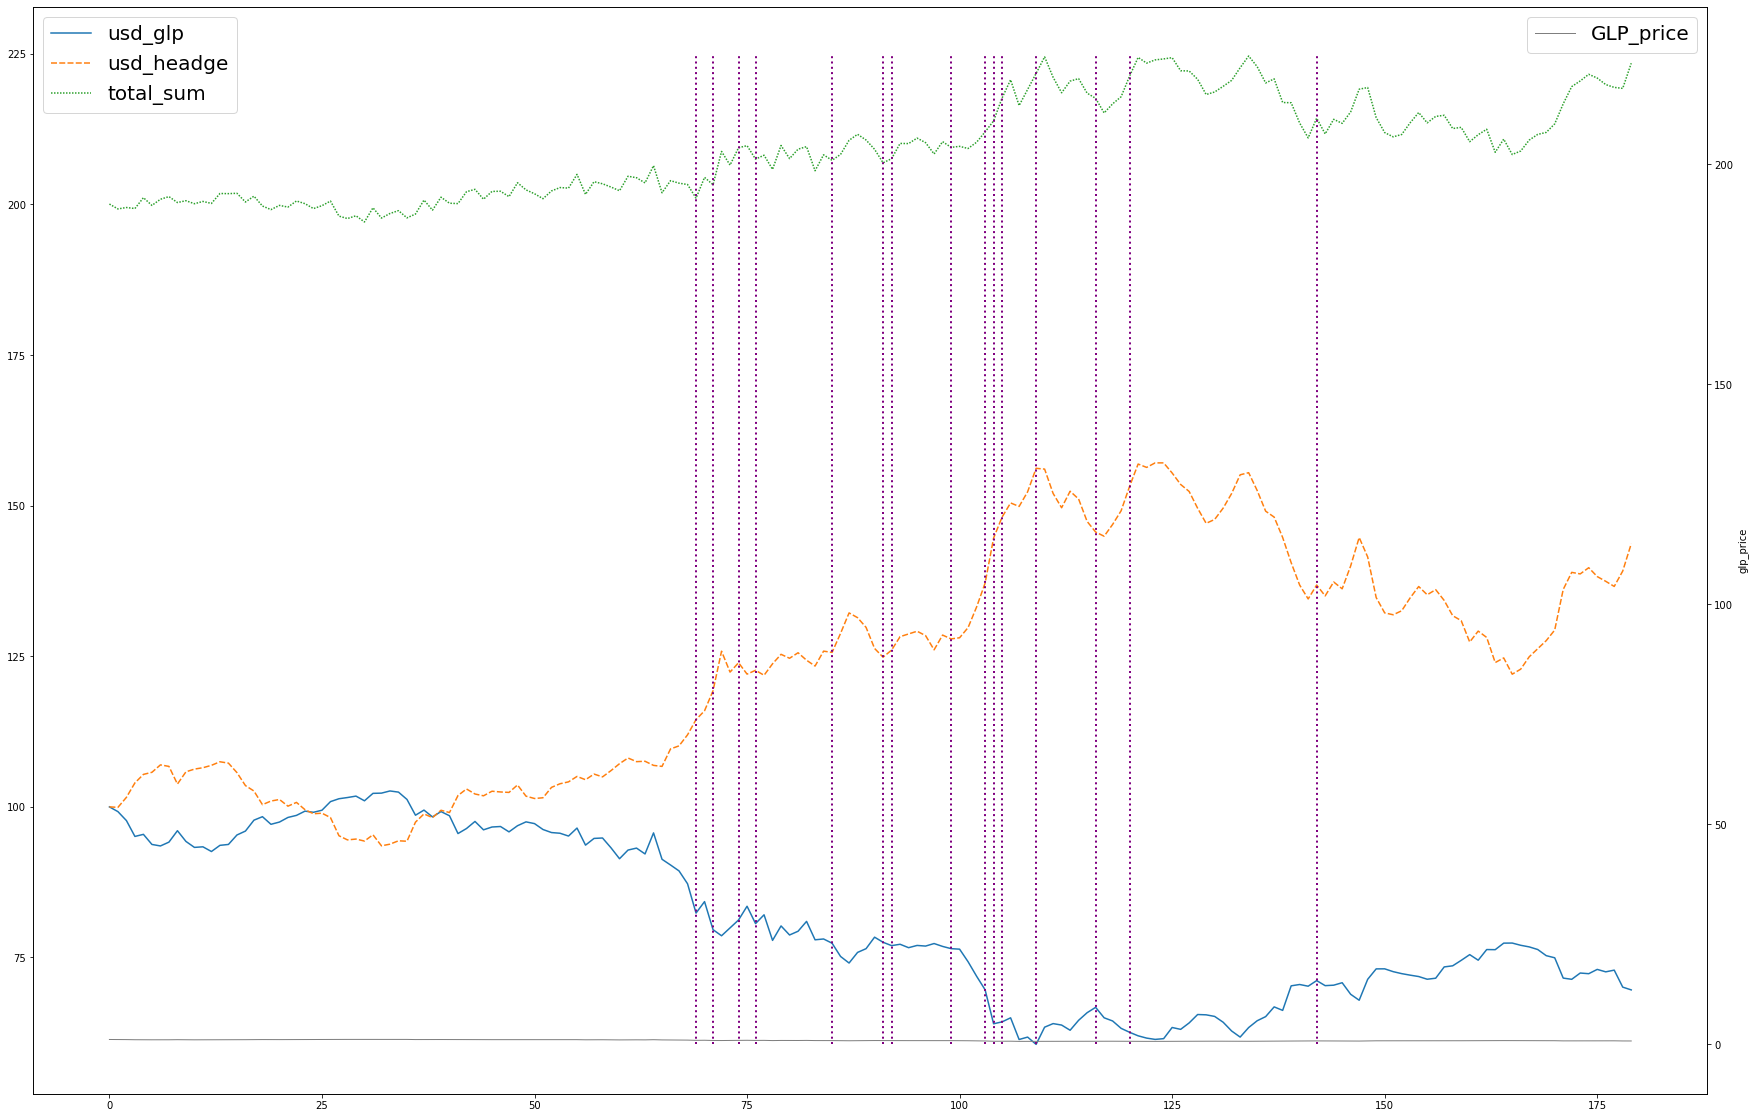

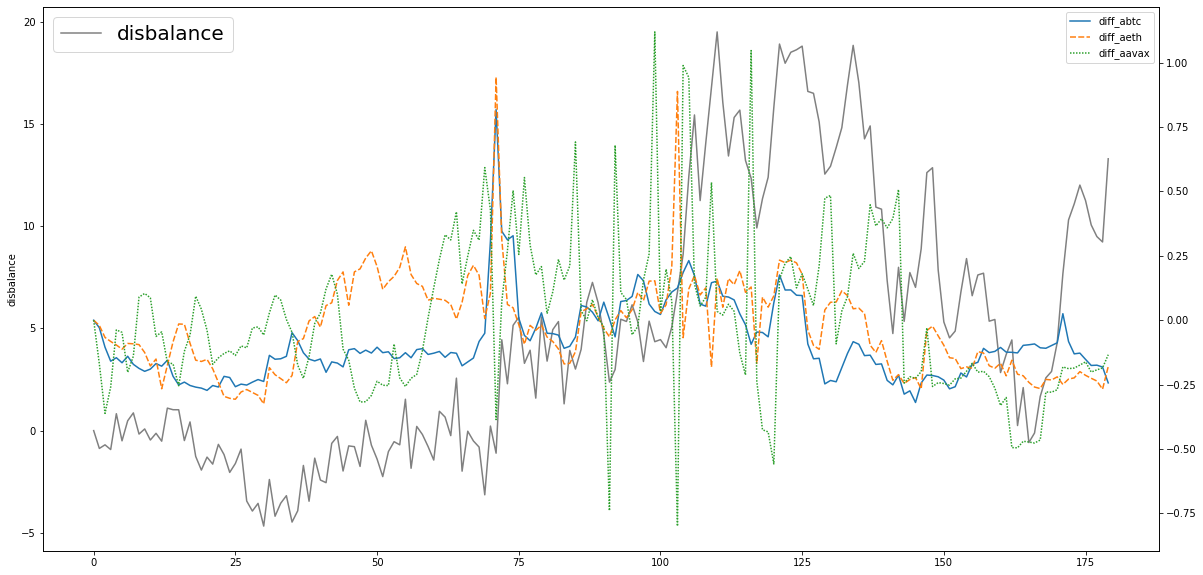

In [173]:
print_result(stat)

In [144]:
stat

,date,position_glp,glp_price,usd_glp,glp_earn,start_usd_hedge_stable,usd_headge,total_fund,disbalance,disbalance_perc,...,amount_btc,amount_eth,amount_avax,curr_glp_amount_btc,curr_glp_amount_eth,curr_glp_amount_avax,diff_abtc,diff_aeth,diff_aavax,rebalance
0,2022-03-01,89.851373,1.112949,100.000000,0.068493,49.610952,100.000000,-0.007437,0.000000,0.000000,...,0.000422,0.005673,0.176105,0.000422,0.005673,0.176105,0.000000,0.000000,0.000000,False
1,2022-03-02,89.851373,1.104166,99.210842,0.136446,49.610952,99.917790,-0.015633,-0.871368,-0.435684,...,0.000422,0.005673,0.176105,0.000410,0.005557,0.146194,-0.029023,-0.020465,-0.169846,False
2,2022-03-03,89.851373,1.087620,97.724107,0.203380,49.610952,101.581070,-0.021679,-0.694823,-0.347412,...,0.000422,0.005673,0.176105,0.000378,0.005294,0.112398,-0.104733,-0.066920,-0.361754,False
3,2022-03-04,89.851373,1.058330,95.092400,0.268512,49.610952,103.981771,-0.025815,-0.925830,-0.462915,...,0.000422,0.005673,0.176105,0.000355,0.005206,0.130434,-0.159066,-0.082463,-0.259341,False
4,2022-03-05,89.851373,1.062167,95.437132,0.333880,49.610952,105.389650,-0.040078,0.826782,0.413391,...,0.000422,0.005673,0.176105,0.000361,0.005128,0.169489,-0.145609,-0.096113,-0.037570,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,2022-08-23,89.851373,0.812693,73.021564,9.807827,60.976374,138.226663,-0.081950,11.248227,5.624113,...,0.001186,0.015760,1.023715,0.001006,0.012387,0.858255,-0.152193,-0.214004,-0.161627,False
176,2022-08-24,89.851373,0.808183,72.616307,9.857564,60.976374,137.440393,-0.023015,10.056700,5.028350,...,0.001186,0.015760,1.023715,0.000978,0.012207,0.817748,-0.175641,-0.225419,-0.201196,False
177,2022-08-25,89.851373,0.811338,72.899817,9.907496,60.976374,136.588114,0.029762,9.487932,4.743966,...,0.001186,0.015760,1.023715,0.000979,0.012039,0.826404,-0.174557,-0.236107,-0.192740,False
178,2022-08-26,89.851373,0.779950,70.079578,9.955495,60.976374,139.145184,0.082175,9.224762,4.612381,...,0.001186,0.015760,1.023715,0.000971,0.011541,0.834058,-0.181683,-0.267698,-0.185264,False
